# Lyric Mood Classification - Mood Classification

In the [word_embeddings](word_embeddings.ipynb) notebook, we demonstrated our embeddings model based on word2vec. In this notebook, we use those embeddings to produce real classification results with a neural network.

First, we split our labeled data into the classic train-dev-test split.

Second, we establish a baseline classification with simple classifiers.

Third, we demonstrate our neural network architecture and model for mood classification.

In [53]:
from index_lyrics import read_file_contents
from label_lyrics import CSV_LABELED_LYRICS
from scrape_lyrics import LYRICS_TXT_DIR
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import lyrics2vec
import datetime
import json
import time
import csv
import os

%matplotlib inline

## Dataset

The dataset consists of a large number of text files where each file represents a different song. The songs are indexed by a csv file produced by `label_lyrics.py`. We can use the index to retrieve a song's lyrics and observe its matched mood.

We drop all songs that are not english, do not have lyrics available, and do not have a matched mood as classifying across languages is out of scope of this project and no classification can be done on a song without lyrics or without a matched mood.

In [2]:
# we leave out the musixmatch id, artist, and title cols
df = pd.read_csv(CSV_LABELED_LYRICS, usecols=['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available', 'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'])
df.columns

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/.venv_w266_project/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available',
       'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'],
      dtype='object')

In [3]:
print('Df shape:', df.shape)
df.describe()

Df shape: (779056, 10)


,is_english,lyrics_available,wordcount,found_tags,matched_mood
count,779056.000000,779056.000000,779056.000000,779056.000000,779056.000000
mean,0.342566,0.420039,87.716389,5.870052,-0.611558
std,0.474571,0.493565,141.151970,19.502538,0.574065
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000
75%,1.000000,1.000000,161.000000,1.000000,0.000000
max,1.000000,1.000000,8623.000000,100.000000,1.000000


In [4]:
df = df[df.is_english == 1]
print('After is_english filter:', df.shape)
df = df[df.lyrics_available == 1]
print('After lyrics_available filter:', df.shape)
df = df[df.matched_mood == 1]
print('After matched_mood filter:', df.shape)

After is_english filter: (266879, 10)
After lyrics_available filter: (266783, 10)
After matched_mood filter: (35835, 10)


In [5]:
# remove no longer needed columns to conserve memory
df = df.drop(['is_english', 'lyrics_available', 'matched_mood'], axis=1)

In [6]:
# create a categorical data column for moods
# thank you: https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
df.mood = pd.Categorical(df.mood)
df['mood_cats'] = df.mood.cat.codes
print(df['mood_cats'].unique())
print(df.shape)

[ 7  2 14 16  3 15 10  0  4 12  1 11  5  8  9 13  6]
(35835, 8)


In [7]:
# read in the lyrics of each song
def extract_lyrics(lyrics_filepath):
    lyrics = ''
    if os.path.exists(lyrics_filepath):
        lyrics = read_file_contents(lyrics_filepath)[0]
    return lyrics

def make_lyrics_txt_path(lyrics_filename):
    return os.path.join(LYRICS_TXT_DIR, lyrics_filename) + '.txt'

# here we make use of panda's apply function to parallelize the IO operation
df['lyrics'] = df.lyrics_filename.apply(lambda x: extract_lyrics(make_lyrics_txt_path(x)))
df.lyrics.head()

7     Electro eroticism\nIntelligence is sexy\nElect...
19    I'm in the dark, I'd like to read his mind\nBu...
27    I'm in the dark, I'd like to read his mind\nBu...
28    One night in Iowa, he and I in a borrowed car\...
32    Shall we agree that just this once\nI'm gonna ...
Name: lyrics, dtype: object

The final number of songs with a matched mood: 35835


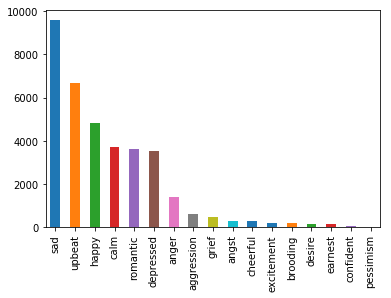

In [8]:
print('The final number of songs with a matched mood:', df.shape[0])
_ = df.mood.value_counts().plot(kind='bar')

## Train, Dev, & Test

With our dataset index in hand, we are prepared to split the data.

In [9]:
# thank you: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
# optional random dataframe shuffle
#df = df.reindex(np.random.permutation(df.index))
np.random.seed(12)
def split_data(data):
    return np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

df_train, df_dev, df_test = split_data(df)

In [10]:
print('Train:', df_train.shape)
print('Dev:', df_dev.shape)
print('Test:', df_test.shape)

Train: (21501, 9)
Dev: (7167, 9)
Test: (7167, 9)


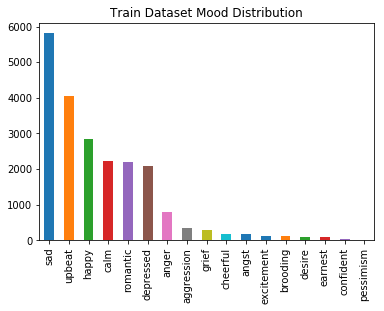

In [11]:
# thank you: https://stackoverflow.com/questions/14992644/turn-pandas-dataframe-of-strings-into-histogram
_ = df_train.mood.value_counts().plot(kind='bar', title='Train Dataset Mood Distribution')

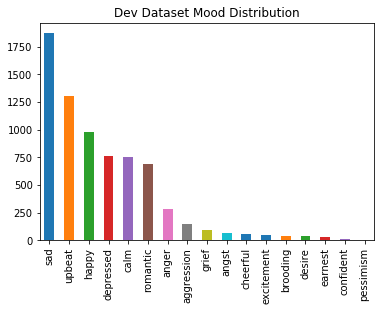

In [12]:
_ = df_dev.mood.value_counts().plot(kind='bar', title='Dev Dataset Mood Distribution')

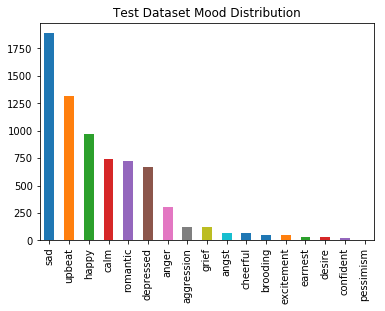

In [13]:
_ = df_test.mood.value_counts().plot(kind='bar', title='Test Dataset Mood Distribution')

## Baselines

### Most-Common-Case Classification

In [14]:
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

def most_common_case_classification(x, y):
    assert len(x) == len(y)
    total_count = len(x)
    common_count = y.value_counts().max()
    accuracy = common_count / total_count
    return accuracy

In [15]:
print('The most common case for each dataset split is')
print('\tTrain:', df_train.mood.value_counts().idxmax())
print('\tDev:', df_dev.mood.value_counts().idxmax())
print('\tTest:', df_test.mood.value_counts().idxmax())
#df_test.loc[df_test.mood_classes.idxmax()].mood
print('The accuracy of the most-common-case classifier for each dataset split is')
print('\tTrain:', pprint_accuracy(most_common_case_classification(df_train.lyrics_filename, df_train.mood)))
print('\tDev:', pprint_accuracy(most_common_case_classification(df_dev.lyrics_filename, df_dev.mood)))
print('\tTest:', pprint_accuracy(most_common_case_classification(df_test.lyrics_filename, df_test.mood)))


The most common case for each dataset split is
	Train: sad
	Dev: sad
	Test: sad
The accuracy of the most-common-case classifier for each dataset split is
	Train: 27.02%
	Dev: 26.11%
	Test: 26.34%


### Naive-Bayes Classification

The Naive-Bayes Classifier will require the actual lyrical text for classification, so we begin by reading into memory the text for each song in our dataset.

Once we have the lyrics, we use the python sklearn package to vectorize and process the lyrical text, fit the Naive Bayes Classifier, and compute the accuracy.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

# convert lyrics to counts and term-frequencies
count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = prep_lyrics_for_nb(df_train.lyrics)
print(x_train_tfidf.shape)
_, x_dev_counts, _, x_dev_tfidf = prep_lyrics_for_nb(df_dev.lyrics, count_vect, tfidf_transformer)
print(x_dev_tfidf.shape)
_, x_test_counts, _, x_test_tfidf = prep_lyrics_for_nb(df_test.lyrics, count_vect, tfidf_transformer)
print(x_test_tfidf.shape)

(21501, 42154)
(7167, 42154)
(7167, 42154)


In [17]:
clf = MultinomialNB().fit(x_train_tfidf, df_train.mood_cats) 
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 29.64%
Naive Bayes Classifier Test Accuracy: 30.25%


### SVM Classification

From [Corona & O'Mahony](https://www.researchgate.net/publication/280733696_An_Exploration_of_Mood_Classification_in_the_Million_Songs_Dataset), SVMs have been used with success in this area. Here we see that they do provide a sizeable increase in accuracy over NB.

In [18]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
            max_iter=5, tol=None).fit(x_train_tfidf, df_train.mood_cats)
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

SVM Classifier Dev Accuracy: 41.61%
SVM Classifier Test Accuracy: 42.47%


## Neural Networks

### CNN

http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

CNNs process textual input different than a Naive Bayes or SVM classifier. We perform the following data processing steps on all lyrics:
* Truncate/extend all songs to the 75% wordcount percentile
* Tokenize lyrics with nltk's word_tokenize function
* Remove all stopwords that match from within nltk's stopwords corpus
* Remove punctuation

In [20]:
pctiles = df.wordcount.describe()
print(pctiles)
cutoff = int(pctiles[pctiles.index.str.startswith('75%')][0])
print('\nAll songs will be limited to {0} words'.format(cutoff))

count    35835.000000
mean       228.451430
std        125.205067
min          1.000000
25%        147.000000
50%        207.000000
75%        282.000000
max       2913.000000
Name: wordcount, dtype: float64

All songs will be limited to 282 words


In [29]:
from importlib import reload
reload(lyrics2vec)
lyrics_vectorizer = lyrics2vec.lyrics2vec.InitFromLyrics()

In [30]:
def normalize_lyrics(lyrics, max_length, lyrics_vectorizer):
    """
    Tokenize, process, shorten/lengthen, and vectorize lyrics
    """
    lyrics = lyrics2vec.lyrics_preprocessing(lyrics)
    if len(lyrics) > max_length:
        lyrics = lyrics[:max_length]
    else:
        lyrics += ['<PAD>'] * (int(max_length) - int(len(lyrics)))

    lyric_vector = lyrics_vectorizer.transform(lyrics)
    return lyric_vector

start = time.time()

# here we make use of panda's apply function to parallelize the IO operation (again)
df_train['normalized_lyrics'] = df_train.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('train data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_train.normalized_lyrics.head())

df_dev['normalized_lyrics'] = df_dev.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('dev data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_dev.normalized_lyrics.head())

df_test['normalized_lyrics'] = df_test.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('test data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_test.normalized_lyrics.head())

print('\nExample of padding:')
example = df_train.normalized_lyrics[df_train.normalized_lyrics.str.len() == cutoff].iloc[0]
print('\tFirst 5 tokens: {0}'.format(example[:5]))
print('\tLast 5 tokens: {0}.'.format(example[-5:]))

print('\nElapsed Time: {0} minutes'.format((time.time() - start) / 60))

train data normalized (0.45991339683532717 minutes)
167425    [22, 1, 16, 6943, 5313, 6, 7, 13141, 2256, 89,...
30039     [296, 287, 215, 305, 1, 12153, 8, 297, 127, 6,...
13452     [112, 2902, 249, 763, 11223, 820, 601, 271, 18...
147252    [2, 210, 210, 13586, 70, 850, 704, 46, 159, 30...
141502    [63, 9, 101, 98, 505, 68, 172, 218, 27, 906, 6...
Name: normalized_lyrics, dtype: object
dev data normalized (0.6108621239662171 minutes)
108764    [65, 64, 1042, 449, 392, 1070, 1, 63, 23, 20, ...
200237    [417, 699, 366, 1353, 11396, 1325, 96, 812, 18...
69545     [37, 93, 15, 3458, 370, 2152, 450, 956, 970, 8...
26241     [238, 41, 86, 487, 29, 48, 312, 3, 492, 68, 30...
99874     [22, 1, 955, 9166, 399, 1273, 9166, 399, 4, 10...
Name: normalized_lyrics, dtype: object
test data normalized (0.7631547927856446 minutes)
113310    [59, 5580, 706, 59, 5580, 59, 5580, 174, 3129,...
160576    [37, 93, 1459, 544, 3950, 670, 3, 499, 2132, 3...
162776    [10909, 446, 132, 549, 96, 5859, 16, 719,

# **Following code is borrowed from [this excellent and very helpful blog post](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) to PoC the validity of the preprocessed tokens and word embeddings**

And here's a walkthrough of that blog post's code: https://agarnitin86.github.io/blog/2016/12/23/text-classification-cnn

In [35]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [79]:
# Parameters
# ==================================================

SAVE_STEP_DATA = True
USE_TIME_AS_KEY = False

# Model Hyperparameters
embedding_dim = 128
filter_sizes = [3,4,5]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.4

# Training parameters
batch_size = 64
num_epochs = 20
evaluate_every = 100
checkpoint_every = 100
num_checkpoints = 5

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print('num_batches_per_epoch = {0}'.format(num_batches_per_epoch))
    for epoch in range(num_epochs):
        print('***********************************************')
        print('Epoch {0}/{1}\n'.format(epoch, num_epochs))
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            print('-----------------------------------------------')
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            print('Epoch {0}/{1}, Batch {2}/{3} (start={4}, end={5})'.format(
                epoch, num_epochs, batch_num, num_batches_per_epoch, start_index, end_index))
            yield shuffled_data[start_index:end_index]
            
def train(vocab_size, x_train, y_train, x_dev, y_dev, x_test, y_test):
    # Training
    # ==================================================

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto()
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                #vocab_size=len(vocab_processor.vocabulary_),
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

            # Output directory for models and summaries
            if USE_TIME_AS_KEY:
                unique_key = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
            else:
                unique_key = 'Em-{0}_FS-{1}_NF-{2}_D-{3}_L2-{4}_B-{5}_Ep-{6}'.format(
                embedding_dim, '-'.join(map(str, filter_sizes)), num_filters, dropout_keep_prob,
                l2_reg_lambda, batch_size, num_epochs)
            out_dir = os.path.abspath(os.path.join(lyrics2vec.LOGS_TF_DIR, "runs", unique_key))
            os.makedirs(out_dir)
            print("Writing to {}\n".format(out_dir))
            
            # dump params to json in case they need to be referenced later
            with open(os.path.join(out_dir, 'model_params.json'), 'w') as outfile:
                model_params = {
                    'embedding_dim': embedding_dim,
                    'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'dropout_keep_prob': dropout_keep_prob,
                    'l2_reg_lambda': l2_reg_lambda,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'evaluate_every': evaluate_every,
                    'checkpoint_every': checkpoint_every,
                    'num_checkpoints': num_checkpoints
                }
                json.dump(model_params, outfile, sort_keys=True)
                
            # Summaries for loss and accuracy
            loss_summary = tf.summary.scalar("loss", cnn.loss)
            acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

            # Train Summaries
            summary_dir = os.path.join(out_dir, "summaries")
            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
            train_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "train"), sess.graph)

            # Dev summaries
            dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
            dev_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "dev"), sess.graph)

            # Test summaries
            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "test"), sess.graph)
            
            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

            # Write vocabulary
            #vocab_processor.save(os.path.join(out_dir, "vocab"))

            # Initialize all variables
            sess.run(tf.global_variables_initializer())

            def train_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                A single training step
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy

            def dev_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run(
                    [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy
                   
            csvwriter = None
            if SAVE_STEP_DATA:
                csvfile = open(os.path.join(out_dir, 'step_data.csv'), 'w')
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['dataset', 'time', 'step', 'loss', 'acc'])
                
            # Generate batches
            batches = batch_iter(
                list(zip(x_train, y_train)), batch_size, num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)
                train_step(x_batch, y_batch, summary_writer=train_summary_writer, step_writer=csvwriter)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, summary_writer=dev_summary_writer, step_writer=csvwriter)
                    print("")
                if current_step % checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))
                    
            print("\nFinal Test Evaluation:")
            dev_step(x_test, y_test, summary_writer=test_summary_writer, step_writer=csvwriter)


In [80]:
# need to convert lyrics into numpy 2d arrays
# need to convert classes into dummies
train(
    vocab_size=lyrics2vec.VOCAB_SIZE,
    x_train=np.array(list(df_train.normalized_lyrics)),
    y_train=pd.get_dummies(df_train.mood).values,
    x_dev=np.array(list(df_dev.normalized_lyrics)),
    y_dev=pd.get_dummies(df_dev.mood).values,
    x_test=np.array(list(df_test.normalized_lyrics)),
    y_test=pd.get_dummies(df_test.mood).values
)

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/sparsity is illegal; using conv-maxpool-4/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using 

2018-11-25T09:10:09.368703: step 39, loss 10.3539, acc 0.171875
-----------------------------------------------
Epoch 0/20, Batch 39/336 (start=2496, end=2560)
2018-11-25T09:10:09.533898: step 40, loss 10.3569, acc 0.140625
-----------------------------------------------
Epoch 0/20, Batch 40/336 (start=2560, end=2624)
2018-11-25T09:10:09.709620: step 41, loss 10.2272, acc 0.171875
-----------------------------------------------
Epoch 0/20, Batch 41/336 (start=2624, end=2688)
2018-11-25T09:10:09.881996: step 42, loss 10.2361, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 42/336 (start=2688, end=2752)
2018-11-25T09:10:10.051390: step 43, loss 9.77138, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 43/336 (start=2752, end=2816)
2018-11-25T09:10:10.225732: step 44, loss 9.90648, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 44/336 (start=2816, end=2880)
2018-11-25T09:10:10.394227: step 45, loss 8.76

2018-11-25T09:10:18.309535: step 91, loss 7.12299, acc 0.125
-----------------------------------------------
Epoch 0/20, Batch 91/336 (start=5824, end=5888)
2018-11-25T09:10:18.477831: step 92, loss 7.1268, acc 0.203125
-----------------------------------------------
Epoch 0/20, Batch 92/336 (start=5888, end=5952)
2018-11-25T09:10:18.649137: step 93, loss 7.16047, acc 0.140625
-----------------------------------------------
Epoch 0/20, Batch 93/336 (start=5952, end=6016)
2018-11-25T09:10:18.827075: step 94, loss 6.89851, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 94/336 (start=6016, end=6080)
2018-11-25T09:10:18.996460: step 95, loss 6.63213, acc 0.234375
-----------------------------------------------
Epoch 0/20, Batch 95/336 (start=6080, end=6144)
2018-11-25T09:10:19.160164: step 96, loss 7.24734, acc 0.234375
-----------------------------------------------
Epoch 0/20, Batch 96/336 (start=6144, end=6208)
2018-11-25T09:10:19.335875: step 97, loss 6.5907

2018-11-25T09:10:29.800968: step 141, loss 5.01829, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 141/336 (start=9024, end=9088)
2018-11-25T09:10:29.975238: step 142, loss 5.57572, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 142/336 (start=9088, end=9152)
2018-11-25T09:10:30.151738: step 143, loss 6.38288, acc 0.140625
-----------------------------------------------
Epoch 0/20, Batch 143/336 (start=9152, end=9216)
2018-11-25T09:10:30.322881: step 144, loss 5.57476, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 144/336 (start=9216, end=9280)
2018-11-25T09:10:30.493049: step 145, loss 5.43533, acc 0.140625
-----------------------------------------------
Epoch 0/20, Batch 145/336 (start=9280, end=9344)
2018-11-25T09:10:30.668945: step 146, loss 5.30442, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 146/336 (start=9344, end=9408)
2018-11-25T09:10:30.840677: step 14

2018-11-25T09:10:38.757693: step 193, loss 4.38741, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 193/336 (start=12352, end=12416)
2018-11-25T09:10:38.935518: step 194, loss 4.26956, acc 0.203125
-----------------------------------------------
Epoch 0/20, Batch 194/336 (start=12416, end=12480)
2018-11-25T09:10:39.106064: step 195, loss 4.63724, acc 0.171875
-----------------------------------------------
Epoch 0/20, Batch 195/336 (start=12480, end=12544)
2018-11-25T09:10:39.276162: step 196, loss 4.20055, acc 0.125
-----------------------------------------------
Epoch 0/20, Batch 196/336 (start=12544, end=12608)
2018-11-25T09:10:39.449969: step 197, loss 4.16451, acc 0.234375
-----------------------------------------------
Epoch 0/20, Batch 197/336 (start=12608, end=12672)
2018-11-25T09:10:39.621723: step 198, loss 4.35778, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 198/336 (start=12672, end=12736)
2018-11-25T09:10:39.8

2018-11-25T09:10:50.153495: step 243, loss 3.54038, acc 0.171875
-----------------------------------------------
Epoch 0/20, Batch 243/336 (start=15552, end=15616)
2018-11-25T09:10:50.321907: step 244, loss 3.69628, acc 0.1875
-----------------------------------------------
Epoch 0/20, Batch 244/336 (start=15616, end=15680)
2018-11-25T09:10:50.493745: step 245, loss 3.82478, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 245/336 (start=15680, end=15744)
2018-11-25T09:10:50.666478: step 246, loss 3.71256, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 246/336 (start=15744, end=15808)
2018-11-25T09:10:50.842229: step 247, loss 3.47668, acc 0.203125
-----------------------------------------------
Epoch 0/20, Batch 247/336 (start=15808, end=15872)
2018-11-25T09:10:51.014420: step 248, loss 3.76929, acc 0.171875
-----------------------------------------------
Epoch 0/20, Batch 248/336 (start=15872, end=15936)
2018-11-25T09:10:51.

2018-11-25T09:10:58.988464: step 295, loss 2.78273, acc 0.234375
-----------------------------------------------
Epoch 0/20, Batch 295/336 (start=18880, end=18944)
2018-11-25T09:10:59.155076: step 296, loss 2.74995, acc 0.296875
-----------------------------------------------
Epoch 0/20, Batch 296/336 (start=18944, end=19008)
2018-11-25T09:10:59.324563: step 297, loss 2.9886, acc 0.234375
-----------------------------------------------
Epoch 0/20, Batch 297/336 (start=19008, end=19072)
2018-11-25T09:10:59.497618: step 298, loss 3.06012, acc 0.1875
-----------------------------------------------
Epoch 0/20, Batch 298/336 (start=19072, end=19136)
2018-11-25T09:10:59.670785: step 299, loss 2.85211, acc 0.375
-----------------------------------------------
Epoch 0/20, Batch 299/336 (start=19136, end=19200)
2018-11-25T09:10:59.837048: step 300, loss 2.9919, acc 0.21875

Evaluation:
2018-11-25T09:11:02.397565: step 300, loss 2.60756, acc 0.27515

Saved model checkpoint to /home/jcworkma/jack

2018-11-25T09:11:10.149101: step 345, loss 2.55788, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 9/336 (start=576, end=640)
2018-11-25T09:11:10.324195: step 346, loss 2.88923, acc 0.234375
-----------------------------------------------
Epoch 1/20, Batch 10/336 (start=640, end=704)
2018-11-25T09:11:10.493650: step 347, loss 2.5512, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 11/336 (start=704, end=768)
2018-11-25T09:11:10.661455: step 348, loss 2.70128, acc 0.203125
-----------------------------------------------
Epoch 1/20, Batch 12/336 (start=768, end=832)
2018-11-25T09:11:10.832323: step 349, loss 2.75856, acc 0.265625
-----------------------------------------------
Epoch 1/20, Batch 13/336 (start=832, end=896)
2018-11-25T09:11:11.010353: step 350, loss 2.77595, acc 0.1875
-----------------------------------------------
Epoch 1/20, Batch 14/336 (start=896, end=960)
2018-11-25T09:11:11.182404: step 351, loss 2.82134, 

2018-11-25T09:11:18.998506: step 397, loss 2.48975, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 61/336 (start=3904, end=3968)
2018-11-25T09:11:19.167377: step 398, loss 2.37341, acc 0.1875
-----------------------------------------------
Epoch 1/20, Batch 62/336 (start=3968, end=4032)
2018-11-25T09:11:19.329967: step 399, loss 2.4567, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 63/336 (start=4032, end=4096)
2018-11-25T09:11:19.494683: step 400, loss 2.81994, acc 0.203125

Evaluation:
2018-11-25T09:11:22.074458: step 400, loss 2.33165, acc 0.270127

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-400

-----------------------------------------------
Epoch 1/20, Batch 64/336 (start=4096, end=4160)
2018-11-25T09:11:22.351610: step 401, loss 2.364, acc 0.25
-----------------------------------------------
Epo

2018-11-25T09:11:30.190055: step 447, loss 2.4568, acc 0.1875
-----------------------------------------------
Epoch 1/20, Batch 111/336 (start=7104, end=7168)
2018-11-25T09:11:30.365857: step 448, loss 2.55259, acc 0.203125
-----------------------------------------------
Epoch 1/20, Batch 112/336 (start=7168, end=7232)
2018-11-25T09:11:30.535642: step 449, loss 2.53628, acc 0.140625
-----------------------------------------------
Epoch 1/20, Batch 113/336 (start=7232, end=7296)
2018-11-25T09:11:30.704310: step 450, loss 2.21644, acc 0.328125
-----------------------------------------------
Epoch 1/20, Batch 114/336 (start=7296, end=7360)
2018-11-25T09:11:30.877083: step 451, loss 2.29843, acc 0.171875
-----------------------------------------------
Epoch 1/20, Batch 115/336 (start=7360, end=7424)
2018-11-25T09:11:31.046277: step 452, loss 2.42586, acc 0.1875
-----------------------------------------------
Epoch 1/20, Batch 116/336 (start=7424, end=7488)
2018-11-25T09:11:31.215207: step 

2018-11-25T09:11:39.024754: step 499, loss 2.10308, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 163/336 (start=10432, end=10496)
2018-11-25T09:11:39.197477: step 500, loss 2.33158, acc 0.203125

Evaluation:
2018-11-25T09:11:41.745464: step 500, loss 2.3037, acc 0.191293

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-500

-----------------------------------------------
Epoch 1/20, Batch 164/336 (start=10496, end=10560)
2018-11-25T09:11:42.054756: step 501, loss 2.37508, acc 0.171875
-----------------------------------------------
Epoch 1/20, Batch 165/336 (start=10560, end=10624)
2018-11-25T09:11:42.213689: step 502, loss 2.20242, acc 0.265625
-----------------------------------------------
Epoch 1/20, Batch 166/336 (start=10624, end=10688)
2018-11-25T09:11:42.391663: step 503, loss 2.48611, acc 0.21875
-----------------------------

2018-11-25T09:11:50.180058: step 549, loss 2.22763, acc 0.265625
-----------------------------------------------
Epoch 1/20, Batch 213/336 (start=13632, end=13696)
2018-11-25T09:11:50.348726: step 550, loss 2.21005, acc 0.234375
-----------------------------------------------
Epoch 1/20, Batch 214/336 (start=13696, end=13760)
2018-11-25T09:11:50.519040: step 551, loss 2.3628, acc 0.1875
-----------------------------------------------
Epoch 1/20, Batch 215/336 (start=13760, end=13824)
2018-11-25T09:11:50.690607: step 552, loss 2.25815, acc 0.203125
-----------------------------------------------
Epoch 1/20, Batch 216/336 (start=13824, end=13888)
2018-11-25T09:11:50.859081: step 553, loss 2.46046, acc 0.234375
-----------------------------------------------
Epoch 1/20, Batch 217/336 (start=13888, end=13952)
2018-11-25T09:11:51.027597: step 554, loss 2.25883, acc 0.328125
-----------------------------------------------
Epoch 1/20, Batch 218/336 (start=13952, end=14016)
2018-11-25T09:11:51

2018-11-25T09:12:01.421474: step 600, loss 2.18677, acc 0.270406

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-600

-----------------------------------------------
Epoch 1/20, Batch 264/336 (start=16896, end=16960)
2018-11-25T09:12:01.713152: step 601, loss 2.25013, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 265/336 (start=16960, end=17024)
2018-11-25T09:12:01.881455: step 602, loss 2.05948, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 266/336 (start=17024, end=17088)
2018-11-25T09:12:02.056838: step 603, loss 2.37102, acc 0.34375
-----------------------------------------------
Epoch 1/20, Batch 267/336 (start=17088, end=17152)
2018-11-25T09:12:02.225664: step 604, loss 2.31625, acc 0.296875
-----------------------------------------------
Epoch 1/20, Batch 268/336 (start=17152, end=17216)
2018-11-

2018-11-25T09:12:10.233080: step 651, loss 2.2668, acc 0.234375
-----------------------------------------------
Epoch 1/20, Batch 315/336 (start=20160, end=20224)
2018-11-25T09:12:10.404294: step 652, loss 2.16034, acc 0.25
-----------------------------------------------
Epoch 1/20, Batch 316/336 (start=20224, end=20288)
2018-11-25T09:12:10.573716: step 653, loss 2.04287, acc 0.28125
-----------------------------------------------
Epoch 1/20, Batch 317/336 (start=20288, end=20352)
2018-11-25T09:12:10.743503: step 654, loss 2.19705, acc 0.3125
-----------------------------------------------
Epoch 1/20, Batch 318/336 (start=20352, end=20416)
2018-11-25T09:12:10.915185: step 655, loss 2.39878, acc 0.203125
-----------------------------------------------
Epoch 1/20, Batch 319/336 (start=20416, end=20480)
2018-11-25T09:12:11.089592: step 656, loss 2.32508, acc 0.265625
-----------------------------------------------
Epoch 1/20, Batch 320/336 (start=20480, end=20544)
2018-11-25T09:12:11.2620

2018-11-25T09:12:21.482074: step 701, loss 2.18805, acc 0.296875
-----------------------------------------------
Epoch 2/20, Batch 29/336 (start=1856, end=1920)
2018-11-25T09:12:21.650546: step 702, loss 2.14459, acc 0.328125
-----------------------------------------------
Epoch 2/20, Batch 30/336 (start=1920, end=1984)
2018-11-25T09:12:21.820213: step 703, loss 2.14357, acc 0.234375
-----------------------------------------------
Epoch 2/20, Batch 31/336 (start=1984, end=2048)
2018-11-25T09:12:21.999144: step 704, loss 2.29096, acc 0.28125
-----------------------------------------------
Epoch 2/20, Batch 32/336 (start=2048, end=2112)
2018-11-25T09:12:22.186364: step 705, loss 2.18908, acc 0.28125
-----------------------------------------------
Epoch 2/20, Batch 33/336 (start=2112, end=2176)
2018-11-25T09:12:22.362982: step 706, loss 2.12234, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 34/336 (start=2176, end=2240)
2018-11-25T09:12:22.530604: step 707, lo

2018-11-25T09:12:30.364493: step 753, loss 2.23998, acc 0.234375
-----------------------------------------------
Epoch 2/20, Batch 81/336 (start=5184, end=5248)
2018-11-25T09:12:30.530618: step 754, loss 2.16842, acc 0.234375
-----------------------------------------------
Epoch 2/20, Batch 82/336 (start=5248, end=5312)
2018-11-25T09:12:30.704856: step 755, loss 2.09936, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 83/336 (start=5312, end=5376)
2018-11-25T09:12:30.878676: step 756, loss 2.18004, acc 0.3125
-----------------------------------------------
Epoch 2/20, Batch 84/336 (start=5376, end=5440)
2018-11-25T09:12:31.044731: step 757, loss 1.98891, acc 0.328125
-----------------------------------------------
Epoch 2/20, Batch 85/336 (start=5440, end=5504)
2018-11-25T09:12:31.214219: step 758, loss 2.02305, acc 0.359375
-----------------------------------------------
Epoch 2/20, Batch 86/336 (start=5504, end=5568)
2018-11-25T09:12:31.382765: step 759, lo

2018-11-25T09:12:41.608219: step 803, loss 2.18946, acc 0.28125
-----------------------------------------------
Epoch 2/20, Batch 131/336 (start=8384, end=8448)
2018-11-25T09:12:41.780634: step 804, loss 2.18005, acc 0.3125
-----------------------------------------------
Epoch 2/20, Batch 132/336 (start=8448, end=8512)
2018-11-25T09:12:41.948165: step 805, loss 2.44637, acc 0.171875
-----------------------------------------------
Epoch 2/20, Batch 133/336 (start=8512, end=8576)
2018-11-25T09:12:42.118375: step 806, loss 2.29179, acc 0.265625
-----------------------------------------------
Epoch 2/20, Batch 134/336 (start=8576, end=8640)
2018-11-25T09:12:42.280605: step 807, loss 2.36031, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 135/336 (start=8640, end=8704)
2018-11-25T09:12:42.447595: step 808, loss 2.1337, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 136/336 (start=8704, end=8768)
2018-11-25T09:12:42.615413: step 809,

2018-11-25T09:12:50.737333: step 854, loss 2.01949, acc 0.296875
-----------------------------------------------
Epoch 2/20, Batch 182/336 (start=11648, end=11712)
2018-11-25T09:12:50.944405: step 855, loss 2.11293, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 183/336 (start=11712, end=11776)
2018-11-25T09:12:51.102147: step 856, loss 2.17153, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 184/336 (start=11776, end=11840)
2018-11-25T09:12:51.311410: step 857, loss 2.27199, acc 0.3125
-----------------------------------------------
Epoch 2/20, Batch 185/336 (start=11840, end=11904)
2018-11-25T09:12:51.476676: step 858, loss 2.17528, acc 0.375
-----------------------------------------------
Epoch 2/20, Batch 186/336 (start=11904, end=11968)
2018-11-25T09:12:51.683558: step 859, loss 2.37792, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 187/336 (start=11968, end=12032)
2018-11-25T09:12:51.873522: step

2018-11-25T09:13:02.570971: step 903, loss 2.04684, acc 0.359375
-----------------------------------------------
Epoch 2/20, Batch 231/336 (start=14784, end=14848)
2018-11-25T09:13:02.743132: step 904, loss 2.13475, acc 0.34375
-----------------------------------------------
Epoch 2/20, Batch 232/336 (start=14848, end=14912)
2018-11-25T09:13:02.918444: step 905, loss 2.12903, acc 0.265625
-----------------------------------------------
Epoch 2/20, Batch 233/336 (start=14912, end=14976)
2018-11-25T09:13:03.087184: step 906, loss 2.21872, acc 0.28125
-----------------------------------------------
Epoch 2/20, Batch 234/336 (start=14976, end=15040)
2018-11-25T09:13:03.264254: step 907, loss 2.09349, acc 0.3125
-----------------------------------------------
Epoch 2/20, Batch 235/336 (start=15040, end=15104)
2018-11-25T09:13:03.430591: step 908, loss 2.12969, acc 0.296875
-----------------------------------------------
Epoch 2/20, Batch 236/336 (start=15104, end=15168)
2018-11-25T09:13:03.

2018-11-25T09:13:11.625228: step 955, loss 1.89672, acc 0.40625
-----------------------------------------------
Epoch 2/20, Batch 283/336 (start=18112, end=18176)
2018-11-25T09:13:11.802437: step 956, loss 2.10413, acc 0.265625
-----------------------------------------------
Epoch 2/20, Batch 284/336 (start=18176, end=18240)
2018-11-25T09:13:11.975520: step 957, loss 2.30624, acc 0.15625
-----------------------------------------------
Epoch 2/20, Batch 285/336 (start=18240, end=18304)
2018-11-25T09:13:12.140621: step 958, loss 1.99868, acc 0.28125
-----------------------------------------------
Epoch 2/20, Batch 286/336 (start=18304, end=18368)
2018-11-25T09:13:12.305137: step 959, loss 2.10881, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 287/336 (start=18368, end=18432)
2018-11-25T09:13:12.479237: step 960, loss 2.08909, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 288/336 (start=18432, end=18496)
2018-11-25T09:13:12.648028:

2018-11-25T09:13:23.080824: step 1005, loss 1.98205, acc 0.328125
-----------------------------------------------
Epoch 2/20, Batch 333/336 (start=21312, end=21376)
2018-11-25T09:13:23.253379: step 1006, loss 1.9204, acc 0.25
-----------------------------------------------
Epoch 2/20, Batch 334/336 (start=21376, end=21440)
2018-11-25T09:13:23.433755: step 1007, loss 2.04167, acc 0.265625
-----------------------------------------------
Epoch 2/20, Batch 335/336 (start=21440, end=21501)
2018-11-25T09:13:23.602454: step 1008, loss 2.44076, acc 0.180328
***********************************************
Epoch 3/20

-----------------------------------------------
Epoch 3/20, Batch 0/336 (start=0, end=64)
2018-11-25T09:13:23.783451: step 1009, loss 2.09197, acc 0.40625
-----------------------------------------------
Epoch 3/20, Batch 1/336 (start=64, end=128)
2018-11-25T09:13:23.958344: step 1010, loss 2.14613, acc 0.3125
-----------------------------------------------
Epoch 3/20, Batch 2/336 (

2018-11-25T09:13:32.136144: step 1057, loss 2.26202, acc 0.28125
-----------------------------------------------
Epoch 3/20, Batch 49/336 (start=3136, end=3200)
2018-11-25T09:13:32.309876: step 1058, loss 2.01202, acc 0.359375
-----------------------------------------------
Epoch 3/20, Batch 50/336 (start=3200, end=3264)
2018-11-25T09:13:32.489749: step 1059, loss 2.03952, acc 0.203125
-----------------------------------------------
Epoch 3/20, Batch 51/336 (start=3264, end=3328)
2018-11-25T09:13:32.659162: step 1060, loss 1.99891, acc 0.328125
-----------------------------------------------
Epoch 3/20, Batch 52/336 (start=3328, end=3392)
2018-11-25T09:13:32.832941: step 1061, loss 2.21345, acc 0.3125
-----------------------------------------------
Epoch 3/20, Batch 53/336 (start=3392, end=3456)
2018-11-25T09:13:33.009316: step 1062, loss 1.8801, acc 0.328125
-----------------------------------------------
Epoch 3/20, Batch 54/336 (start=3456, end=3520)
2018-11-25T09:13:33.177606: step

2018-11-25T09:13:43.645678: step 1107, loss 2.21898, acc 0.265625
-----------------------------------------------
Epoch 3/20, Batch 99/336 (start=6336, end=6400)
2018-11-25T09:13:43.826327: step 1108, loss 2.11777, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 100/336 (start=6400, end=6464)
2018-11-25T09:13:43.996892: step 1109, loss 2.28393, acc 0.265625
-----------------------------------------------
Epoch 3/20, Batch 101/336 (start=6464, end=6528)
2018-11-25T09:13:44.173236: step 1110, loss 2.17206, acc 0.34375
-----------------------------------------------
Epoch 3/20, Batch 102/336 (start=6528, end=6592)
2018-11-25T09:13:44.342162: step 1111, loss 2.11361, acc 0.234375
-----------------------------------------------
Epoch 3/20, Batch 103/336 (start=6592, end=6656)
2018-11-25T09:13:44.512290: step 1112, loss 2.05956, acc 0.34375
-----------------------------------------------
Epoch 3/20, Batch 104/336 (start=6656, end=6720)
2018-11-25T09:13:44.67801

2018-11-25T09:13:52.571067: step 1158, loss 2.33387, acc 0.28125
-----------------------------------------------
Epoch 3/20, Batch 150/336 (start=9600, end=9664)
2018-11-25T09:13:52.742269: step 1159, loss 1.86498, acc 0.34375
-----------------------------------------------
Epoch 3/20, Batch 151/336 (start=9664, end=9728)
2018-11-25T09:13:52.910095: step 1160, loss 2.12891, acc 0.3125
-----------------------------------------------
Epoch 3/20, Batch 152/336 (start=9728, end=9792)
2018-11-25T09:13:53.082133: step 1161, loss 2.05061, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 153/336 (start=9792, end=9856)
2018-11-25T09:13:53.256776: step 1162, loss 2.26602, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 154/336 (start=9856, end=9920)
2018-11-25T09:13:53.436509: step 1163, loss 2.17249, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 155/336 (start=9920, end=9984)
2018-11-25T09:13:53.609048

2018-11-25T09:14:03.859154: step 1207, loss 2.10795, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 199/336 (start=12736, end=12800)
2018-11-25T09:14:04.029469: step 1208, loss 1.8781, acc 0.5
-----------------------------------------------
Epoch 3/20, Batch 200/336 (start=12800, end=12864)
2018-11-25T09:14:04.204807: step 1209, loss 2.08268, acc 0.21875
-----------------------------------------------
Epoch 3/20, Batch 201/336 (start=12864, end=12928)
2018-11-25T09:14:04.413419: step 1210, loss 2.03683, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 202/336 (start=12928, end=12992)
2018-11-25T09:14:04.582608: step 1211, loss 2.25235, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 203/336 (start=12992, end=13056)
2018-11-25T09:14:04.750560: step 1212, loss 2.19824, acc 0.21875
-----------------------------------------------
Epoch 3/20, Batch 204/336 (start=13056, end=13120)
2018-11-25T09:14:0

2018-11-25T09:14:12.645992: step 1258, loss 2.07609, acc 0.203125
-----------------------------------------------
Epoch 3/20, Batch 250/336 (start=16000, end=16064)
2018-11-25T09:14:12.816060: step 1259, loss 2.27505, acc 0.265625
-----------------------------------------------
Epoch 3/20, Batch 251/336 (start=16064, end=16128)
2018-11-25T09:14:13.002379: step 1260, loss 1.91707, acc 0.4375
-----------------------------------------------
Epoch 3/20, Batch 252/336 (start=16128, end=16192)
2018-11-25T09:14:13.170555: step 1261, loss 2.11335, acc 0.359375
-----------------------------------------------
Epoch 3/20, Batch 253/336 (start=16192, end=16256)
2018-11-25T09:14:13.339421: step 1262, loss 2.06679, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 254/336 (start=16256, end=16320)
2018-11-25T09:14:13.508342: step 1263, loss 2.24733, acc 0.28125
-----------------------------------------------
Epoch 3/20, Batch 255/336 (start=16320, end=16384)
2018-11-25T09

2018-11-25T09:14:24.134918: step 1308, loss 2.13451, acc 0.296875
-----------------------------------------------
Epoch 3/20, Batch 300/336 (start=19200, end=19264)
2018-11-25T09:14:24.306671: step 1309, loss 2.10409, acc 0.234375
-----------------------------------------------
Epoch 3/20, Batch 301/336 (start=19264, end=19328)
2018-11-25T09:14:24.478577: step 1310, loss 1.99421, acc 0.34375
-----------------------------------------------
Epoch 3/20, Batch 302/336 (start=19328, end=19392)
2018-11-25T09:14:24.672527: step 1311, loss 2.04303, acc 0.28125
-----------------------------------------------
Epoch 3/20, Batch 303/336 (start=19392, end=19456)
2018-11-25T09:14:24.848511: step 1312, loss 2.15157, acc 0.3125
-----------------------------------------------
Epoch 3/20, Batch 304/336 (start=19456, end=19520)
2018-11-25T09:14:25.022943: step 1313, loss 2.27121, acc 0.28125
-----------------------------------------------
Epoch 3/20, Batch 305/336 (start=19520, end=19584)
2018-11-25T09:1

2018-11-25T09:14:33.212910: step 1360, loss 2.10672, acc 0.375
-----------------------------------------------
Epoch 4/20, Batch 16/336 (start=1024, end=1088)
2018-11-25T09:14:33.378922: step 1361, loss 2.21515, acc 0.390625
-----------------------------------------------
Epoch 4/20, Batch 17/336 (start=1088, end=1152)
2018-11-25T09:14:33.553829: step 1362, loss 1.95814, acc 0.34375
-----------------------------------------------
Epoch 4/20, Batch 18/336 (start=1152, end=1216)
2018-11-25T09:14:33.720786: step 1363, loss 1.87955, acc 0.328125
-----------------------------------------------
Epoch 4/20, Batch 19/336 (start=1216, end=1280)
2018-11-25T09:14:33.891518: step 1364, loss 2.12647, acc 0.25
-----------------------------------------------
Epoch 4/20, Batch 20/336 (start=1280, end=1344)
2018-11-25T09:14:34.060384: step 1365, loss 2.02318, acc 0.296875
-----------------------------------------------
Epoch 4/20, Batch 21/336 (start=1344, end=1408)
2018-11-25T09:14:34.231401: step 136

2018-11-25T09:14:44.824763: step 1411, loss 2.13013, acc 0.265625
-----------------------------------------------
Epoch 4/20, Batch 67/336 (start=4288, end=4352)
2018-11-25T09:14:44.992381: step 1412, loss 2.08034, acc 0.265625
-----------------------------------------------
Epoch 4/20, Batch 68/336 (start=4352, end=4416)
2018-11-25T09:14:45.166912: step 1413, loss 2.07445, acc 0.34375
-----------------------------------------------
Epoch 4/20, Batch 69/336 (start=4416, end=4480)
2018-11-25T09:14:45.339385: step 1414, loss 1.92079, acc 0.4375
-----------------------------------------------
Epoch 4/20, Batch 70/336 (start=4480, end=4544)
2018-11-25T09:14:45.513939: step 1415, loss 2.0528, acc 0.359375
-----------------------------------------------
Epoch 4/20, Batch 71/336 (start=4544, end=4608)
2018-11-25T09:14:45.685453: step 1416, loss 2.14266, acc 0.328125
-----------------------------------------------
Epoch 4/20, Batch 72/336 (start=4608, end=4672)
2018-11-25T09:14:45.863073: step

2018-11-25T09:14:53.888246: step 1463, loss 2.25753, acc 0.25
-----------------------------------------------
Epoch 4/20, Batch 119/336 (start=7616, end=7680)
2018-11-25T09:14:54.057125: step 1464, loss 2.08056, acc 0.328125
-----------------------------------------------
Epoch 4/20, Batch 120/336 (start=7680, end=7744)
2018-11-25T09:14:54.229178: step 1465, loss 2.03849, acc 0.28125
-----------------------------------------------
Epoch 4/20, Batch 121/336 (start=7744, end=7808)
2018-11-25T09:14:54.399616: step 1466, loss 2.06698, acc 0.328125
-----------------------------------------------
Epoch 4/20, Batch 122/336 (start=7808, end=7872)
2018-11-25T09:14:54.570283: step 1467, loss 2.21117, acc 0.28125
-----------------------------------------------
Epoch 4/20, Batch 123/336 (start=7872, end=7936)
2018-11-25T09:14:54.739155: step 1468, loss 2.11676, acc 0.328125
-----------------------------------------------
Epoch 4/20, Batch 124/336 (start=7936, end=8000)
2018-11-25T09:14:54.906007: 

2018-11-25T09:15:05.344372: step 1513, loss 2.1986, acc 0.359375
-----------------------------------------------
Epoch 4/20, Batch 169/336 (start=10816, end=10880)
2018-11-25T09:15:05.516173: step 1514, loss 2.15962, acc 0.25
-----------------------------------------------
Epoch 4/20, Batch 170/336 (start=10880, end=10944)
2018-11-25T09:15:05.681022: step 1515, loss 2.03016, acc 0.359375
-----------------------------------------------
Epoch 4/20, Batch 171/336 (start=10944, end=11008)
2018-11-25T09:15:05.854881: step 1516, loss 2.1838, acc 0.265625
-----------------------------------------------
Epoch 4/20, Batch 172/336 (start=11008, end=11072)
2018-11-25T09:15:06.031785: step 1517, loss 2.02186, acc 0.359375
-----------------------------------------------
Epoch 4/20, Batch 173/336 (start=11072, end=11136)
2018-11-25T09:15:06.205559: step 1518, loss 2.08782, acc 0.21875
-----------------------------------------------
Epoch 4/20, Batch 174/336 (start=11136, end=11200)
2018-11-25T09:15:

2018-11-25T09:15:14.189850: step 1564, loss 2.36185, acc 0.203125
-----------------------------------------------
Epoch 4/20, Batch 220/336 (start=14080, end=14144)
2018-11-25T09:15:14.364559: step 1565, loss 2.1256, acc 0.234375
-----------------------------------------------
Epoch 4/20, Batch 221/336 (start=14144, end=14208)
2018-11-25T09:15:14.534710: step 1566, loss 2.19861, acc 0.28125
-----------------------------------------------
Epoch 4/20, Batch 222/336 (start=14208, end=14272)
2018-11-25T09:15:14.712771: step 1567, loss 1.96916, acc 0.375
-----------------------------------------------
Epoch 4/20, Batch 223/336 (start=14272, end=14336)
2018-11-25T09:15:14.882469: step 1568, loss 2.09432, acc 0.3125
-----------------------------------------------
Epoch 4/20, Batch 224/336 (start=14336, end=14400)
2018-11-25T09:15:15.050729: step 1569, loss 2.08063, acc 0.28125
-----------------------------------------------
Epoch 4/20, Batch 225/336 (start=14400, end=14464)
2018-11-25T09:15:1

2018-11-25T09:15:25.456687: step 1613, loss 1.97185, acc 0.28125
-----------------------------------------------
Epoch 4/20, Batch 269/336 (start=17216, end=17280)
2018-11-25T09:15:25.626273: step 1614, loss 2.24693, acc 0.265625
-----------------------------------------------
Epoch 4/20, Batch 270/336 (start=17280, end=17344)
2018-11-25T09:15:25.797057: step 1615, loss 2.13294, acc 0.296875
-----------------------------------------------
Epoch 4/20, Batch 271/336 (start=17344, end=17408)
2018-11-25T09:15:25.978955: step 1616, loss 2.21339, acc 0.234375
-----------------------------------------------
Epoch 4/20, Batch 272/336 (start=17408, end=17472)
2018-11-25T09:15:26.144625: step 1617, loss 2.01264, acc 0.34375
-----------------------------------------------
Epoch 4/20, Batch 273/336 (start=17472, end=17536)
2018-11-25T09:15:26.311212: step 1618, loss 2.2028, acc 0.234375
-----------------------------------------------
Epoch 4/20, Batch 274/336 (start=17536, end=17600)
2018-11-25T09

2018-11-25T09:15:34.353736: step 1664, loss 2.01491, acc 0.296875
-----------------------------------------------
Epoch 4/20, Batch 320/336 (start=20480, end=20544)
2018-11-25T09:15:34.529024: step 1665, loss 2.06984, acc 0.28125
-----------------------------------------------
Epoch 4/20, Batch 321/336 (start=20544, end=20608)
2018-11-25T09:15:34.699988: step 1666, loss 1.98771, acc 0.28125
-----------------------------------------------
Epoch 4/20, Batch 322/336 (start=20608, end=20672)
2018-11-25T09:15:34.880748: step 1667, loss 2.05662, acc 0.4375
-----------------------------------------------
Epoch 4/20, Batch 323/336 (start=20672, end=20736)
2018-11-25T09:15:35.052078: step 1668, loss 1.82597, acc 0.546875
-----------------------------------------------
Epoch 4/20, Batch 324/336 (start=20736, end=20800)
2018-11-25T09:15:35.224008: step 1669, loss 1.75108, acc 0.390625
-----------------------------------------------
Epoch 4/20, Batch 325/336 (start=20800, end=20864)
2018-11-25T09:

2018-11-25T09:15:45.652727: step 1713, loss 1.95777, acc 0.296875
-----------------------------------------------
Epoch 5/20, Batch 33/336 (start=2112, end=2176)
2018-11-25T09:15:45.829190: step 1714, loss 1.92423, acc 0.359375
-----------------------------------------------
Epoch 5/20, Batch 34/336 (start=2176, end=2240)
2018-11-25T09:15:45.996316: step 1715, loss 2.08845, acc 0.3125
-----------------------------------------------
Epoch 5/20, Batch 35/336 (start=2240, end=2304)
2018-11-25T09:15:46.167567: step 1716, loss 2.09225, acc 0.265625
-----------------------------------------------
Epoch 5/20, Batch 36/336 (start=2304, end=2368)
2018-11-25T09:15:46.337150: step 1717, loss 2.07556, acc 0.265625
-----------------------------------------------
Epoch 5/20, Batch 37/336 (start=2368, end=2432)
2018-11-25T09:15:46.524635: step 1718, loss 1.98392, acc 0.359375
-----------------------------------------------
Epoch 5/20, Batch 38/336 (start=2432, end=2496)
2018-11-25T09:15:46.697385: st

2018-11-25T09:15:54.500021: step 1764, loss 1.95525, acc 0.296875
-----------------------------------------------
Epoch 5/20, Batch 84/336 (start=5376, end=5440)
2018-11-25T09:15:54.668690: step 1765, loss 2.03652, acc 0.328125
-----------------------------------------------
Epoch 5/20, Batch 85/336 (start=5440, end=5504)
2018-11-25T09:15:54.842457: step 1766, loss 1.79321, acc 0.390625
-----------------------------------------------
Epoch 5/20, Batch 86/336 (start=5504, end=5568)
2018-11-25T09:15:55.005029: step 1767, loss 1.90784, acc 0.40625
-----------------------------------------------
Epoch 5/20, Batch 87/336 (start=5568, end=5632)
2018-11-25T09:15:55.176795: step 1768, loss 1.9329, acc 0.390625
-----------------------------------------------
Epoch 5/20, Batch 88/336 (start=5632, end=5696)
2018-11-25T09:15:55.351293: step 1769, loss 2.13521, acc 0.359375
-----------------------------------------------
Epoch 5/20, Batch 89/336 (start=5696, end=5760)
2018-11-25T09:15:55.515340: st

2018-11-25T09:16:06.050342: step 1815, loss 1.92957, acc 0.40625
-----------------------------------------------
Epoch 5/20, Batch 135/336 (start=8640, end=8704)
2018-11-25T09:16:06.215405: step 1816, loss 2.08315, acc 0.421875
-----------------------------------------------
Epoch 5/20, Batch 136/336 (start=8704, end=8768)
2018-11-25T09:16:06.390374: step 1817, loss 2.3957, acc 0.203125
-----------------------------------------------
Epoch 5/20, Batch 137/336 (start=8768, end=8832)
2018-11-25T09:16:06.554913: step 1818, loss 1.9617, acc 0.375
-----------------------------------------------
Epoch 5/20, Batch 138/336 (start=8832, end=8896)
2018-11-25T09:16:06.719976: step 1819, loss 2.0333, acc 0.28125
-----------------------------------------------
Epoch 5/20, Batch 139/336 (start=8896, end=8960)
2018-11-25T09:16:06.894886: step 1820, loss 2.16528, acc 0.3125
-----------------------------------------------
Epoch 5/20, Batch 140/336 (start=8960, end=9024)
2018-11-25T09:16:07.066642: step

2018-11-25T09:16:14.980695: step 1867, loss 1.98648, acc 0.359375
-----------------------------------------------
Epoch 5/20, Batch 187/336 (start=11968, end=12032)
2018-11-25T09:16:15.156682: step 1868, loss 2.00637, acc 0.328125
-----------------------------------------------
Epoch 5/20, Batch 188/336 (start=12032, end=12096)
2018-11-25T09:16:15.327364: step 1869, loss 1.97861, acc 0.28125
-----------------------------------------------
Epoch 5/20, Batch 189/336 (start=12096, end=12160)
2018-11-25T09:16:15.500607: step 1870, loss 1.94328, acc 0.328125
-----------------------------------------------
Epoch 5/20, Batch 190/336 (start=12160, end=12224)
2018-11-25T09:16:15.676567: step 1871, loss 2.18293, acc 0.203125
-----------------------------------------------
Epoch 5/20, Batch 191/336 (start=12224, end=12288)
2018-11-25T09:16:15.850165: step 1872, loss 1.87319, acc 0.328125
-----------------------------------------------
Epoch 5/20, Batch 192/336 (start=12288, end=12352)
2018-11-25T

2018-11-25T09:16:26.400762: step 1917, loss 2.0541, acc 0.296875
-----------------------------------------------
Epoch 5/20, Batch 237/336 (start=15168, end=15232)
2018-11-25T09:16:26.577482: step 1918, loss 1.98219, acc 0.390625
-----------------------------------------------
Epoch 5/20, Batch 238/336 (start=15232, end=15296)
2018-11-25T09:16:26.751041: step 1919, loss 2.22445, acc 0.28125
-----------------------------------------------
Epoch 5/20, Batch 239/336 (start=15296, end=15360)
2018-11-25T09:16:26.918832: step 1920, loss 2.0092, acc 0.34375
-----------------------------------------------
Epoch 5/20, Batch 240/336 (start=15360, end=15424)
2018-11-25T09:16:27.087838: step 1921, loss 1.95623, acc 0.328125
-----------------------------------------------
Epoch 5/20, Batch 241/336 (start=15424, end=15488)
2018-11-25T09:16:27.256290: step 1922, loss 2.00752, acc 0.34375
-----------------------------------------------
Epoch 5/20, Batch 242/336 (start=15488, end=15552)
2018-11-25T09:1

2018-11-25T09:16:35.310890: step 1968, loss 2.15464, acc 0.296875
-----------------------------------------------
Epoch 5/20, Batch 288/336 (start=18432, end=18496)
2018-11-25T09:16:35.483415: step 1969, loss 1.82346, acc 0.40625
-----------------------------------------------
Epoch 5/20, Batch 289/336 (start=18496, end=18560)
2018-11-25T09:16:35.653832: step 1970, loss 2.25839, acc 0.1875
-----------------------------------------------
Epoch 5/20, Batch 290/336 (start=18560, end=18624)
2018-11-25T09:16:35.838321: step 1971, loss 2.05209, acc 0.296875
-----------------------------------------------
Epoch 5/20, Batch 291/336 (start=18624, end=18688)
2018-11-25T09:16:36.011987: step 1972, loss 2.12346, acc 0.234375
-----------------------------------------------
Epoch 5/20, Batch 292/336 (start=18688, end=18752)
2018-11-25T09:16:36.183550: step 1973, loss 2.00733, acc 0.328125
-----------------------------------------------
Epoch 5/20, Batch 293/336 (start=18752, end=18816)
2018-11-25T09

2018-11-25T09:16:46.539296: step 2017, loss 1.87826, acc 0.328125
-----------------------------------------------
Epoch 6/20, Batch 1/336 (start=64, end=128)
2018-11-25T09:16:46.707092: step 2018, loss 2.12851, acc 0.34375
-----------------------------------------------
Epoch 6/20, Batch 2/336 (start=128, end=192)
2018-11-25T09:16:46.873570: step 2019, loss 2.19829, acc 0.296875
-----------------------------------------------
Epoch 6/20, Batch 3/336 (start=192, end=256)
2018-11-25T09:16:47.047915: step 2020, loss 2.21529, acc 0.359375
-----------------------------------------------
Epoch 6/20, Batch 4/336 (start=256, end=320)
2018-11-25T09:16:47.209432: step 2021, loss 1.90727, acc 0.3125
-----------------------------------------------
Epoch 6/20, Batch 5/336 (start=320, end=384)
2018-11-25T09:16:47.379898: step 2022, loss 1.95181, acc 0.40625
-----------------------------------------------
Epoch 6/20, Batch 6/336 (start=384, end=448)
2018-11-25T09:16:47.552582: step 2023, loss 2.05209

2018-11-25T09:16:55.681758: step 2070, loss 2.06788, acc 0.3125
-----------------------------------------------
Epoch 6/20, Batch 54/336 (start=3456, end=3520)
2018-11-25T09:16:55.856821: step 2071, loss 1.82846, acc 0.34375
-----------------------------------------------
Epoch 6/20, Batch 55/336 (start=3520, end=3584)
2018-11-25T09:16:56.025498: step 2072, loss 1.99883, acc 0.390625
-----------------------------------------------
Epoch 6/20, Batch 56/336 (start=3584, end=3648)
2018-11-25T09:16:56.200796: step 2073, loss 2.13451, acc 0.34375
-----------------------------------------------
Epoch 6/20, Batch 57/336 (start=3648, end=3712)
2018-11-25T09:16:56.374216: step 2074, loss 1.90825, acc 0.3125
-----------------------------------------------
Epoch 6/20, Batch 58/336 (start=3712, end=3776)
2018-11-25T09:16:56.545998: step 2075, loss 2.061, acc 0.359375
-----------------------------------------------
Epoch 6/20, Batch 59/336 (start=3776, end=3840)
2018-11-25T09:16:56.715771: step 207

2018-11-25T09:17:07.270673: step 2121, loss 1.98201, acc 0.40625
-----------------------------------------------
Epoch 6/20, Batch 105/336 (start=6720, end=6784)
2018-11-25T09:17:07.446431: step 2122, loss 1.85725, acc 0.375
-----------------------------------------------
Epoch 6/20, Batch 106/336 (start=6784, end=6848)
2018-11-25T09:17:07.609930: step 2123, loss 2.04466, acc 0.296875
-----------------------------------------------
Epoch 6/20, Batch 107/336 (start=6848, end=6912)
2018-11-25T09:17:07.778060: step 2124, loss 2.14156, acc 0.34375
-----------------------------------------------
Epoch 6/20, Batch 108/336 (start=6912, end=6976)
2018-11-25T09:17:07.950591: step 2125, loss 1.90285, acc 0.421875
-----------------------------------------------
Epoch 6/20, Batch 109/336 (start=6976, end=7040)
2018-11-25T09:17:08.120959: step 2126, loss 1.85789, acc 0.375
-----------------------------------------------
Epoch 6/20, Batch 110/336 (start=7040, end=7104)
2018-11-25T09:17:08.296996: st

2018-11-25T09:17:16.116350: step 2172, loss 1.9135, acc 0.359375
-----------------------------------------------
Epoch 6/20, Batch 156/336 (start=9984, end=10048)
2018-11-25T09:17:16.285694: step 2173, loss 2.27227, acc 0.328125
-----------------------------------------------
Epoch 6/20, Batch 157/336 (start=10048, end=10112)
2018-11-25T09:17:16.454455: step 2174, loss 2.04535, acc 0.390625
-----------------------------------------------
Epoch 6/20, Batch 158/336 (start=10112, end=10176)
2018-11-25T09:17:16.626262: step 2175, loss 1.78044, acc 0.390625
-----------------------------------------------
Epoch 6/20, Batch 159/336 (start=10176, end=10240)
2018-11-25T09:17:16.797896: step 2176, loss 1.87325, acc 0.421875
-----------------------------------------------
Epoch 6/20, Batch 160/336 (start=10240, end=10304)
2018-11-25T09:17:16.963918: step 2177, loss 2.04758, acc 0.4375
-----------------------------------------------
Epoch 6/20, Batch 161/336 (start=10304, end=10368)
2018-11-25T09:

2018-11-25T09:17:27.347044: step 2221, loss 1.92852, acc 0.390625
-----------------------------------------------
Epoch 6/20, Batch 205/336 (start=13120, end=13184)
2018-11-25T09:17:27.522376: step 2222, loss 1.98253, acc 0.28125
-----------------------------------------------
Epoch 6/20, Batch 206/336 (start=13184, end=13248)
2018-11-25T09:17:27.697650: step 2223, loss 2.08277, acc 0.3125
-----------------------------------------------
Epoch 6/20, Batch 207/336 (start=13248, end=13312)
2018-11-25T09:17:27.869307: step 2224, loss 2.04097, acc 0.328125
-----------------------------------------------
Epoch 6/20, Batch 208/336 (start=13312, end=13376)
2018-11-25T09:17:28.041499: step 2225, loss 2.02942, acc 0.3125
-----------------------------------------------
Epoch 6/20, Batch 209/336 (start=13376, end=13440)
2018-11-25T09:17:28.213062: step 2226, loss 1.93787, acc 0.34375
-----------------------------------------------
Epoch 6/20, Batch 210/336 (start=13440, end=13504)
2018-11-25T09:17

2018-11-25T09:17:35.970827: step 2271, loss 1.96118, acc 0.375
-----------------------------------------------
Epoch 6/20, Batch 255/336 (start=16320, end=16384)
2018-11-25T09:17:36.139092: step 2272, loss 2.06874, acc 0.3125
-----------------------------------------------
Epoch 6/20, Batch 256/336 (start=16384, end=16448)
2018-11-25T09:17:36.318358: step 2273, loss 1.97236, acc 0.34375
-----------------------------------------------
Epoch 6/20, Batch 257/336 (start=16448, end=16512)
2018-11-25T09:17:36.488731: step 2274, loss 1.92457, acc 0.4375
-----------------------------------------------
Epoch 6/20, Batch 258/336 (start=16512, end=16576)
2018-11-25T09:17:36.654758: step 2275, loss 2.02066, acc 0.375
-----------------------------------------------
Epoch 6/20, Batch 259/336 (start=16576, end=16640)
2018-11-25T09:17:36.820234: step 2276, loss 2.13769, acc 0.3125
-----------------------------------------------
Epoch 6/20, Batch 260/336 (start=16640, end=16704)
2018-11-25T09:17:36.989

2018-11-25T09:17:47.342065: step 2321, loss 1.83714, acc 0.390625
-----------------------------------------------
Epoch 6/20, Batch 305/336 (start=19520, end=19584)
2018-11-25T09:17:47.514613: step 2322, loss 1.91296, acc 0.390625
-----------------------------------------------
Epoch 6/20, Batch 306/336 (start=19584, end=19648)
2018-11-25T09:17:47.684102: step 2323, loss 1.88085, acc 0.265625
-----------------------------------------------
Epoch 6/20, Batch 307/336 (start=19648, end=19712)
2018-11-25T09:17:47.858239: step 2324, loss 2.16335, acc 0.296875
-----------------------------------------------
Epoch 6/20, Batch 308/336 (start=19712, end=19776)
2018-11-25T09:17:48.027142: step 2325, loss 1.81425, acc 0.40625
-----------------------------------------------
Epoch 6/20, Batch 309/336 (start=19776, end=19840)
2018-11-25T09:17:48.195156: step 2326, loss 1.97182, acc 0.328125
-----------------------------------------------
Epoch 6/20, Batch 310/336 (start=19840, end=19904)
2018-11-25T

2018-11-25T09:17:56.391359: step 2373, loss 1.88885, acc 0.4375
-----------------------------------------------
Epoch 7/20, Batch 21/336 (start=1344, end=1408)
2018-11-25T09:17:56.564482: step 2374, loss 1.74226, acc 0.421875
-----------------------------------------------
Epoch 7/20, Batch 22/336 (start=1408, end=1472)
2018-11-25T09:17:56.749098: step 2375, loss 1.82424, acc 0.375
-----------------------------------------------
Epoch 7/20, Batch 23/336 (start=1472, end=1536)
2018-11-25T09:17:56.923807: step 2376, loss 1.79325, acc 0.453125
-----------------------------------------------
Epoch 7/20, Batch 24/336 (start=1536, end=1600)
2018-11-25T09:17:57.099986: step 2377, loss 1.94451, acc 0.375
-----------------------------------------------
Epoch 7/20, Batch 25/336 (start=1600, end=1664)
2018-11-25T09:17:57.271867: step 2378, loss 1.94418, acc 0.375
-----------------------------------------------
Epoch 7/20, Batch 26/336 (start=1664, end=1728)
2018-11-25T09:17:57.440476: step 2379, 

2018-11-25T09:18:07.931822: step 2423, loss 2.08203, acc 0.3125
-----------------------------------------------
Epoch 7/20, Batch 71/336 (start=4544, end=4608)
2018-11-25T09:18:08.100688: step 2424, loss 2.1032, acc 0.375
-----------------------------------------------
Epoch 7/20, Batch 72/336 (start=4608, end=4672)
2018-11-25T09:18:08.272018: step 2425, loss 2.14284, acc 0.375
-----------------------------------------------
Epoch 7/20, Batch 73/336 (start=4672, end=4736)
2018-11-25T09:18:08.452782: step 2426, loss 1.94804, acc 0.484375
-----------------------------------------------
Epoch 7/20, Batch 74/336 (start=4736, end=4800)
2018-11-25T09:18:08.626596: step 2427, loss 1.85704, acc 0.5
-----------------------------------------------
Epoch 7/20, Batch 75/336 (start=4800, end=4864)
2018-11-25T09:18:08.805534: step 2428, loss 2.1069, acc 0.328125
-----------------------------------------------
Epoch 7/20, Batch 76/336 (start=4864, end=4928)
2018-11-25T09:18:08.979832: step 2429, loss

2018-11-25T09:18:16.768415: step 2474, loss 2.24416, acc 0.265625
-----------------------------------------------
Epoch 7/20, Batch 122/336 (start=7808, end=7872)
2018-11-25T09:18:16.940948: step 2475, loss 2.02632, acc 0.34375
-----------------------------------------------
Epoch 7/20, Batch 123/336 (start=7872, end=7936)
2018-11-25T09:18:17.123408: step 2476, loss 2.07743, acc 0.453125
-----------------------------------------------
Epoch 7/20, Batch 124/336 (start=7936, end=8000)
2018-11-25T09:18:17.295282: step 2477, loss 1.93347, acc 0.4375
-----------------------------------------------
Epoch 7/20, Batch 125/336 (start=8000, end=8064)
2018-11-25T09:18:17.470390: step 2478, loss 1.9904, acc 0.328125
-----------------------------------------------
Epoch 7/20, Batch 126/336 (start=8064, end=8128)
2018-11-25T09:18:17.641116: step 2479, loss 1.83789, acc 0.421875
-----------------------------------------------
Epoch 7/20, Batch 127/336 (start=8128, end=8192)
2018-11-25T09:18:17.811526

2018-11-25T09:18:28.302652: step 2524, loss 2.0398, acc 0.359375
-----------------------------------------------
Epoch 7/20, Batch 172/336 (start=11008, end=11072)
2018-11-25T09:18:28.473885: step 2525, loss 2.09849, acc 0.296875
-----------------------------------------------
Epoch 7/20, Batch 173/336 (start=11072, end=11136)
2018-11-25T09:18:28.643681: step 2526, loss 2.05482, acc 0.390625
-----------------------------------------------
Epoch 7/20, Batch 174/336 (start=11136, end=11200)
2018-11-25T09:18:28.816805: step 2527, loss 1.92838, acc 0.421875
-----------------------------------------------
Epoch 7/20, Batch 175/336 (start=11200, end=11264)
2018-11-25T09:18:28.984967: step 2528, loss 1.8445, acc 0.390625
-----------------------------------------------
Epoch 7/20, Batch 176/336 (start=11264, end=11328)
2018-11-25T09:18:29.164909: step 2529, loss 2.01476, acc 0.34375
-----------------------------------------------
Epoch 7/20, Batch 177/336 (start=11328, end=11392)
2018-11-25T09

2018-11-25T09:18:36.908875: step 2574, loss 2.08578, acc 0.375
-----------------------------------------------
Epoch 7/20, Batch 222/336 (start=14208, end=14272)
2018-11-25T09:18:37.082686: step 2575, loss 1.94054, acc 0.359375
-----------------------------------------------
Epoch 7/20, Batch 223/336 (start=14272, end=14336)
2018-11-25T09:18:37.255800: step 2576, loss 1.86847, acc 0.4375
-----------------------------------------------
Epoch 7/20, Batch 224/336 (start=14336, end=14400)
2018-11-25T09:18:37.422577: step 2577, loss 1.88169, acc 0.328125
-----------------------------------------------
Epoch 7/20, Batch 225/336 (start=14400, end=14464)
2018-11-25T09:18:37.596305: step 2578, loss 1.97988, acc 0.34375
-----------------------------------------------
Epoch 7/20, Batch 226/336 (start=14464, end=14528)
2018-11-25T09:18:37.770542: step 2579, loss 2.12616, acc 0.296875
-----------------------------------------------
Epoch 7/20, Batch 227/336 (start=14528, end=14592)
2018-11-25T09:18

2018-11-25T09:18:48.202398: step 2623, loss 1.91562, acc 0.28125
-----------------------------------------------
Epoch 7/20, Batch 271/336 (start=17344, end=17408)
2018-11-25T09:18:48.378628: step 2624, loss 2.05408, acc 0.40625
-----------------------------------------------
Epoch 7/20, Batch 272/336 (start=17408, end=17472)
2018-11-25T09:18:48.564015: step 2625, loss 1.78653, acc 0.375
-----------------------------------------------
Epoch 7/20, Batch 273/336 (start=17472, end=17536)
2018-11-25T09:18:48.734462: step 2626, loss 1.84838, acc 0.5
-----------------------------------------------
Epoch 7/20, Batch 274/336 (start=17536, end=17600)
2018-11-25T09:18:48.903387: step 2627, loss 1.95673, acc 0.3125
-----------------------------------------------
Epoch 7/20, Batch 275/336 (start=17600, end=17664)
2018-11-25T09:18:49.074062: step 2628, loss 1.95776, acc 0.359375
-----------------------------------------------
Epoch 7/20, Batch 276/336 (start=17664, end=17728)
2018-11-25T09:18:49.25

2018-11-25T09:18:57.076640: step 2674, loss 1.73604, acc 0.46875
-----------------------------------------------
Epoch 7/20, Batch 322/336 (start=20608, end=20672)
2018-11-25T09:18:57.246109: step 2675, loss 2.05444, acc 0.375
-----------------------------------------------
Epoch 7/20, Batch 323/336 (start=20672, end=20736)
2018-11-25T09:18:57.416329: step 2676, loss 1.94629, acc 0.4375
-----------------------------------------------
Epoch 7/20, Batch 324/336 (start=20736, end=20800)
2018-11-25T09:18:57.582326: step 2677, loss 1.88725, acc 0.359375
-----------------------------------------------
Epoch 7/20, Batch 325/336 (start=20800, end=20864)
2018-11-25T09:18:57.749111: step 2678, loss 1.59962, acc 0.515625
-----------------------------------------------
Epoch 7/20, Batch 326/336 (start=20864, end=20928)
2018-11-25T09:18:57.926085: step 2679, loss 1.76657, acc 0.4375
-----------------------------------------------
Epoch 7/20, Batch 327/336 (start=20928, end=20992)
2018-11-25T09:18:5

2018-11-25T09:19:08.627685: step 2725, loss 1.84906, acc 0.40625
-----------------------------------------------
Epoch 8/20, Batch 37/336 (start=2368, end=2432)
2018-11-25T09:19:08.795116: step 2726, loss 1.96393, acc 0.359375
-----------------------------------------------
Epoch 8/20, Batch 38/336 (start=2432, end=2496)
2018-11-25T09:19:08.970644: step 2727, loss 1.58569, acc 0.5
-----------------------------------------------
Epoch 8/20, Batch 39/336 (start=2496, end=2560)
2018-11-25T09:19:09.140923: step 2728, loss 1.8292, acc 0.5
-----------------------------------------------
Epoch 8/20, Batch 40/336 (start=2560, end=2624)
2018-11-25T09:19:09.324447: step 2729, loss 1.74446, acc 0.4375
-----------------------------------------------
Epoch 8/20, Batch 41/336 (start=2624, end=2688)
2018-11-25T09:19:09.491845: step 2730, loss 1.85367, acc 0.453125
-----------------------------------------------
Epoch 8/20, Batch 42/336 (start=2688, end=2752)
2018-11-25T09:19:09.672956: step 2731, los

2018-11-25T09:19:17.622029: step 2777, loss 1.83837, acc 0.40625
-----------------------------------------------
Epoch 8/20, Batch 89/336 (start=5696, end=5760)
2018-11-25T09:19:17.793412: step 2778, loss 1.82064, acc 0.453125
-----------------------------------------------
Epoch 8/20, Batch 90/336 (start=5760, end=5824)
2018-11-25T09:19:17.964086: step 2779, loss 1.94461, acc 0.421875
-----------------------------------------------
Epoch 8/20, Batch 91/336 (start=5824, end=5888)
2018-11-25T09:19:18.136730: step 2780, loss 2.10334, acc 0.390625
-----------------------------------------------
Epoch 8/20, Batch 92/336 (start=5888, end=5952)
2018-11-25T09:19:18.306726: step 2781, loss 2.04392, acc 0.328125
-----------------------------------------------
Epoch 8/20, Batch 93/336 (start=5952, end=6016)
2018-11-25T09:19:18.483261: step 2782, loss 1.74414, acc 0.484375
-----------------------------------------------
Epoch 8/20, Batch 94/336 (start=6016, end=6080)
2018-11-25T09:19:18.653738: s

2018-11-25T09:19:29.270289: step 2828, loss 1.81701, acc 0.421875
-----------------------------------------------
Epoch 8/20, Batch 140/336 (start=8960, end=9024)
2018-11-25T09:19:29.443957: step 2829, loss 1.98815, acc 0.359375
-----------------------------------------------
Epoch 8/20, Batch 141/336 (start=9024, end=9088)
2018-11-25T09:19:29.614477: step 2830, loss 2.02282, acc 0.4375
-----------------------------------------------
Epoch 8/20, Batch 142/336 (start=9088, end=9152)
2018-11-25T09:19:29.788347: step 2831, loss 1.8896, acc 0.3125
-----------------------------------------------
Epoch 8/20, Batch 143/336 (start=9152, end=9216)
2018-11-25T09:19:29.962298: step 2832, loss 1.73747, acc 0.53125
-----------------------------------------------
Epoch 8/20, Batch 144/336 (start=9216, end=9280)
2018-11-25T09:19:30.144918: step 2833, loss 1.90737, acc 0.4375
-----------------------------------------------
Epoch 8/20, Batch 145/336 (start=9280, end=9344)
2018-11-25T09:19:30.320100: st

2018-11-25T09:19:38.166339: step 2880, loss 1.78547, acc 0.5
-----------------------------------------------
Epoch 8/20, Batch 192/336 (start=12288, end=12352)
2018-11-25T09:19:38.338600: step 2881, loss 1.88186, acc 0.375
-----------------------------------------------
Epoch 8/20, Batch 193/336 (start=12352, end=12416)
2018-11-25T09:19:38.513870: step 2882, loss 1.76916, acc 0.453125
-----------------------------------------------
Epoch 8/20, Batch 194/336 (start=12416, end=12480)
2018-11-25T09:19:38.686425: step 2883, loss 1.71871, acc 0.46875
-----------------------------------------------
Epoch 8/20, Batch 195/336 (start=12480, end=12544)
2018-11-25T09:19:38.881727: step 2884, loss 2.12469, acc 0.28125
-----------------------------------------------
Epoch 8/20, Batch 196/336 (start=12544, end=12608)
2018-11-25T09:19:39.047096: step 2885, loss 2.06387, acc 0.46875
-----------------------------------------------
Epoch 8/20, Batch 197/336 (start=12608, end=12672)
2018-11-25T09:19:39.2

2018-11-25T09:19:49.337618: step 2929, loss 1.86251, acc 0.4375
-----------------------------------------------
Epoch 8/20, Batch 241/336 (start=15424, end=15488)
2018-11-25T09:19:49.511048: step 2930, loss 1.68815, acc 0.5
-----------------------------------------------
Epoch 8/20, Batch 242/336 (start=15488, end=15552)
2018-11-25T09:19:49.681036: step 2931, loss 1.88985, acc 0.390625
-----------------------------------------------
Epoch 8/20, Batch 243/336 (start=15552, end=15616)
2018-11-25T09:19:49.858381: step 2932, loss 2.02601, acc 0.375
-----------------------------------------------
Epoch 8/20, Batch 244/336 (start=15616, end=15680)
2018-11-25T09:19:50.027127: step 2933, loss 1.67136, acc 0.5
-----------------------------------------------
Epoch 8/20, Batch 245/336 (start=15680, end=15744)
2018-11-25T09:19:50.194356: step 2934, loss 1.87578, acc 0.40625
-----------------------------------------------
Epoch 8/20, Batch 246/336 (start=15744, end=15808)
2018-11-25T09:19:50.365079

2018-11-25T09:19:58.235460: step 2980, loss 1.88037, acc 0.484375
-----------------------------------------------
Epoch 8/20, Batch 292/336 (start=18688, end=18752)
2018-11-25T09:19:58.401858: step 2981, loss 1.78175, acc 0.359375
-----------------------------------------------
Epoch 8/20, Batch 293/336 (start=18752, end=18816)
2018-11-25T09:19:58.584952: step 2982, loss 1.96255, acc 0.421875
-----------------------------------------------
Epoch 8/20, Batch 294/336 (start=18816, end=18880)
2018-11-25T09:19:58.756990: step 2983, loss 1.98054, acc 0.359375
-----------------------------------------------
Epoch 8/20, Batch 295/336 (start=18880, end=18944)
2018-11-25T09:19:58.933181: step 2984, loss 1.78663, acc 0.453125
-----------------------------------------------
Epoch 8/20, Batch 296/336 (start=18944, end=19008)
2018-11-25T09:19:59.104424: step 2985, loss 2.17811, acc 0.3125
-----------------------------------------------
Epoch 8/20, Batch 297/336 (start=19008, end=19072)
2018-11-25T0

2018-11-25T09:20:09.439970: step 3029, loss 1.69049, acc 0.5
-----------------------------------------------
Epoch 9/20, Batch 5/336 (start=320, end=384)
2018-11-25T09:20:09.610580: step 3030, loss 1.78671, acc 0.46875
-----------------------------------------------
Epoch 9/20, Batch 6/336 (start=384, end=448)
2018-11-25T09:20:09.771108: step 3031, loss 1.86437, acc 0.53125
-----------------------------------------------
Epoch 9/20, Batch 7/336 (start=448, end=512)
2018-11-25T09:20:09.944195: step 3032, loss 1.67725, acc 0.5625
-----------------------------------------------
Epoch 9/20, Batch 8/336 (start=512, end=576)
2018-11-25T09:20:10.137858: step 3033, loss 1.5937, acc 0.546875
-----------------------------------------------
Epoch 9/20, Batch 9/336 (start=576, end=640)
2018-11-25T09:20:10.310259: step 3034, loss 1.78645, acc 0.484375
-----------------------------------------------
Epoch 9/20, Batch 10/336 (start=640, end=704)
2018-11-25T09:20:10.486557: step 3035, loss 1.98436, ac

2018-11-25T09:20:18.478166: step 3081, loss 1.58913, acc 0.484375
-----------------------------------------------
Epoch 9/20, Batch 57/336 (start=3648, end=3712)
2018-11-25T09:20:18.659928: step 3082, loss 1.87929, acc 0.375
-----------------------------------------------
Epoch 9/20, Batch 58/336 (start=3712, end=3776)
2018-11-25T09:20:18.826925: step 3083, loss 1.54096, acc 0.46875
-----------------------------------------------
Epoch 9/20, Batch 59/336 (start=3776, end=3840)
2018-11-25T09:20:19.005167: step 3084, loss 1.81198, acc 0.515625
-----------------------------------------------
Epoch 9/20, Batch 60/336 (start=3840, end=3904)
2018-11-25T09:20:19.177402: step 3085, loss 1.93641, acc 0.5
-----------------------------------------------
Epoch 9/20, Batch 61/336 (start=3904, end=3968)
2018-11-25T09:20:19.346676: step 3086, loss 1.64454, acc 0.5
-----------------------------------------------
Epoch 9/20, Batch 62/336 (start=3968, end=4032)
2018-11-25T09:20:19.525021: step 3087, los

2018-11-25T09:20:29.932578: step 3131, loss 1.53757, acc 0.5
-----------------------------------------------
Epoch 9/20, Batch 107/336 (start=6848, end=6912)
2018-11-25T09:20:30.106136: step 3132, loss 1.80725, acc 0.546875
-----------------------------------------------
Epoch 9/20, Batch 108/336 (start=6912, end=6976)
2018-11-25T09:20:30.288900: step 3133, loss 1.62087, acc 0.484375
-----------------------------------------------
Epoch 9/20, Batch 109/336 (start=6976, end=7040)
2018-11-25T09:20:30.457410: step 3134, loss 1.79801, acc 0.53125
-----------------------------------------------
Epoch 9/20, Batch 110/336 (start=7040, end=7104)
2018-11-25T09:20:30.630484: step 3135, loss 1.76491, acc 0.40625
-----------------------------------------------
Epoch 9/20, Batch 111/336 (start=7104, end=7168)
2018-11-25T09:20:30.802806: step 3136, loss 1.72004, acc 0.453125
-----------------------------------------------
Epoch 9/20, Batch 112/336 (start=7168, end=7232)
2018-11-25T09:20:30.980297: s

2018-11-25T09:20:38.949871: step 3182, loss 1.57418, acc 0.625
-----------------------------------------------
Epoch 9/20, Batch 158/336 (start=10112, end=10176)
2018-11-25T09:20:39.124260: step 3183, loss 1.6508, acc 0.453125
-----------------------------------------------
Epoch 9/20, Batch 159/336 (start=10176, end=10240)
2018-11-25T09:20:39.294298: step 3184, loss 1.72978, acc 0.453125
-----------------------------------------------
Epoch 9/20, Batch 160/336 (start=10240, end=10304)
2018-11-25T09:20:39.499490: step 3185, loss 1.62701, acc 0.46875
-----------------------------------------------
Epoch 9/20, Batch 161/336 (start=10304, end=10368)
2018-11-25T09:20:39.666909: step 3186, loss 1.53734, acc 0.53125
-----------------------------------------------
Epoch 9/20, Batch 162/336 (start=10368, end=10432)
2018-11-25T09:20:39.838045: step 3187, loss 1.73652, acc 0.40625
-----------------------------------------------
Epoch 9/20, Batch 163/336 (start=10432, end=10496)
2018-11-25T09:20:

2018-11-25T09:20:50.232064: step 3231, loss 1.87983, acc 0.4375
-----------------------------------------------
Epoch 9/20, Batch 207/336 (start=13248, end=13312)
2018-11-25T09:20:50.402244: step 3232, loss 1.62231, acc 0.5
-----------------------------------------------
Epoch 9/20, Batch 208/336 (start=13312, end=13376)
2018-11-25T09:20:50.569679: step 3233, loss 1.9085, acc 0.375
-----------------------------------------------
Epoch 9/20, Batch 209/336 (start=13376, end=13440)
2018-11-25T09:20:50.744080: step 3234, loss 1.84145, acc 0.46875
-----------------------------------------------
Epoch 9/20, Batch 210/336 (start=13440, end=13504)
2018-11-25T09:20:50.911905: step 3235, loss 1.91093, acc 0.421875
-----------------------------------------------
Epoch 9/20, Batch 211/336 (start=13504, end=13568)
2018-11-25T09:20:51.089733: step 3236, loss 1.80405, acc 0.4375
-----------------------------------------------
Epoch 9/20, Batch 212/336 (start=13568, end=13632)
2018-11-25T09:20:51.2562

2018-11-25T09:20:58.783908: step 3281, loss 1.5855, acc 0.46875
-----------------------------------------------
Epoch 9/20, Batch 257/336 (start=16448, end=16512)
2018-11-25T09:20:58.957968: step 3282, loss 1.72858, acc 0.484375
-----------------------------------------------
Epoch 9/20, Batch 258/336 (start=16512, end=16576)
2018-11-25T09:20:59.135763: step 3283, loss 1.86299, acc 0.453125
-----------------------------------------------
Epoch 9/20, Batch 259/336 (start=16576, end=16640)
2018-11-25T09:20:59.306043: step 3284, loss 1.80061, acc 0.484375
-----------------------------------------------
Epoch 9/20, Batch 260/336 (start=16640, end=16704)
2018-11-25T09:20:59.474727: step 3285, loss 1.73211, acc 0.46875
-----------------------------------------------
Epoch 9/20, Batch 261/336 (start=16704, end=16768)
2018-11-25T09:20:59.647626: step 3286, loss 1.6222, acc 0.578125
-----------------------------------------------
Epoch 9/20, Batch 262/336 (start=16768, end=16832)
2018-11-25T09:

2018-11-25T09:21:09.943248: step 3331, loss 1.962, acc 0.46875
-----------------------------------------------
Epoch 9/20, Batch 307/336 (start=19648, end=19712)
2018-11-25T09:21:10.115076: step 3332, loss 1.7627, acc 0.484375
-----------------------------------------------
Epoch 9/20, Batch 308/336 (start=19712, end=19776)
2018-11-25T09:21:10.293115: step 3333, loss 1.82505, acc 0.421875
-----------------------------------------------
Epoch 9/20, Batch 309/336 (start=19776, end=19840)
2018-11-25T09:21:10.461761: step 3334, loss 1.91859, acc 0.40625
-----------------------------------------------
Epoch 9/20, Batch 310/336 (start=19840, end=19904)
2018-11-25T09:21:10.631975: step 3335, loss 1.61513, acc 0.484375
-----------------------------------------------
Epoch 9/20, Batch 311/336 (start=19904, end=19968)
2018-11-25T09:21:10.803402: step 3336, loss 1.76186, acc 0.453125
-----------------------------------------------
Epoch 9/20, Batch 312/336 (start=19968, end=20032)
2018-11-25T09:2

2018-11-25T09:21:18.783893: step 3383, loss 1.60002, acc 0.515625
-----------------------------------------------
Epoch 10/20, Batch 23/336 (start=1472, end=1536)
2018-11-25T09:21:18.949394: step 3384, loss 1.48089, acc 0.578125
-----------------------------------------------
Epoch 10/20, Batch 24/336 (start=1536, end=1600)
2018-11-25T09:21:19.119161: step 3385, loss 1.74106, acc 0.515625
-----------------------------------------------
Epoch 10/20, Batch 25/336 (start=1600, end=1664)
2018-11-25T09:21:19.293095: step 3386, loss 1.92247, acc 0.390625
-----------------------------------------------
Epoch 10/20, Batch 26/336 (start=1664, end=1728)
2018-11-25T09:21:19.467212: step 3387, loss 1.67708, acc 0.546875
-----------------------------------------------
Epoch 10/20, Batch 27/336 (start=1728, end=1792)
2018-11-25T09:21:19.640533: step 3388, loss 1.50611, acc 0.578125
-----------------------------------------------
Epoch 10/20, Batch 28/336 (start=1792, end=1856)
2018-11-25T09:21:19.80

2018-11-25T09:21:29.935921: step 3433, loss 1.61651, acc 0.453125
-----------------------------------------------
Epoch 10/20, Batch 73/336 (start=4672, end=4736)
2018-11-25T09:21:30.104337: step 3434, loss 1.69202, acc 0.53125
-----------------------------------------------
Epoch 10/20, Batch 74/336 (start=4736, end=4800)
2018-11-25T09:21:30.265451: step 3435, loss 1.77937, acc 0.53125
-----------------------------------------------
Epoch 10/20, Batch 75/336 (start=4800, end=4864)
2018-11-25T09:21:30.435906: step 3436, loss 1.69757, acc 0.5
-----------------------------------------------
Epoch 10/20, Batch 76/336 (start=4864, end=4928)
2018-11-25T09:21:30.606953: step 3437, loss 1.72919, acc 0.453125
-----------------------------------------------
Epoch 10/20, Batch 77/336 (start=4928, end=4992)
2018-11-25T09:21:30.774244: step 3438, loss 1.78986, acc 0.484375
-----------------------------------------------
Epoch 10/20, Batch 78/336 (start=4992, end=5056)
2018-11-25T09:21:30.941883: s

2018-11-25T09:21:38.756285: step 3485, loss 1.63547, acc 0.484375
-----------------------------------------------
Epoch 10/20, Batch 125/336 (start=8000, end=8064)
2018-11-25T09:21:38.925096: step 3486, loss 1.6466, acc 0.515625
-----------------------------------------------
Epoch 10/20, Batch 126/336 (start=8064, end=8128)
2018-11-25T09:21:39.089180: step 3487, loss 1.76613, acc 0.390625
-----------------------------------------------
Epoch 10/20, Batch 127/336 (start=8128, end=8192)
2018-11-25T09:21:39.258581: step 3488, loss 1.69127, acc 0.53125
-----------------------------------------------
Epoch 10/20, Batch 128/336 (start=8192, end=8256)
2018-11-25T09:21:39.430661: step 3489, loss 1.6514, acc 0.484375
-----------------------------------------------
Epoch 10/20, Batch 129/336 (start=8256, end=8320)
2018-11-25T09:21:39.599577: step 3490, loss 1.95532, acc 0.40625
-----------------------------------------------
Epoch 10/20, Batch 130/336 (start=8320, end=8384)
2018-11-25T09:21:39.

2018-11-25T09:21:49.987840: step 3535, loss 1.7127, acc 0.453125
-----------------------------------------------
Epoch 10/20, Batch 175/336 (start=11200, end=11264)
2018-11-25T09:21:50.157035: step 3536, loss 1.67154, acc 0.46875
-----------------------------------------------
Epoch 10/20, Batch 176/336 (start=11264, end=11328)
2018-11-25T09:21:50.327486: step 3537, loss 1.82551, acc 0.453125
-----------------------------------------------
Epoch 10/20, Batch 177/336 (start=11328, end=11392)
2018-11-25T09:21:50.495569: step 3538, loss 1.79612, acc 0.515625
-----------------------------------------------
Epoch 10/20, Batch 178/336 (start=11392, end=11456)
2018-11-25T09:21:50.660799: step 3539, loss 1.77539, acc 0.515625
-----------------------------------------------
Epoch 10/20, Batch 179/336 (start=11456, end=11520)
2018-11-25T09:21:50.839921: step 3540, loss 1.84068, acc 0.53125
-----------------------------------------------
Epoch 10/20, Batch 180/336 (start=11520, end=11584)
2018-11

2018-11-25T09:21:58.476772: step 3585, loss 1.46672, acc 0.578125
-----------------------------------------------
Epoch 10/20, Batch 225/336 (start=14400, end=14464)
2018-11-25T09:21:58.645170: step 3586, loss 1.70554, acc 0.53125
-----------------------------------------------
Epoch 10/20, Batch 226/336 (start=14464, end=14528)
2018-11-25T09:21:58.813774: step 3587, loss 1.65667, acc 0.578125
-----------------------------------------------
Epoch 10/20, Batch 227/336 (start=14528, end=14592)
2018-11-25T09:21:58.985304: step 3588, loss 1.75723, acc 0.421875
-----------------------------------------------
Epoch 10/20, Batch 228/336 (start=14592, end=14656)
2018-11-25T09:21:59.162404: step 3589, loss 1.78036, acc 0.453125
-----------------------------------------------
Epoch 10/20, Batch 229/336 (start=14656, end=14720)
2018-11-25T09:21:59.325370: step 3590, loss 1.68968, acc 0.453125
-----------------------------------------------
Epoch 10/20, Batch 230/336 (start=14720, end=14784)
2018-

2018-11-25T09:22:09.690833: step 3635, loss 1.70004, acc 0.53125
-----------------------------------------------
Epoch 10/20, Batch 275/336 (start=17600, end=17664)
2018-11-25T09:22:09.855311: step 3636, loss 1.79953, acc 0.4375
-----------------------------------------------
Epoch 10/20, Batch 276/336 (start=17664, end=17728)
2018-11-25T09:22:10.025288: step 3637, loss 1.83004, acc 0.546875
-----------------------------------------------
Epoch 10/20, Batch 277/336 (start=17728, end=17792)
2018-11-25T09:22:10.193332: step 3638, loss 1.76539, acc 0.46875
-----------------------------------------------
Epoch 10/20, Batch 278/336 (start=17792, end=17856)
2018-11-25T09:22:10.367061: step 3639, loss 1.47345, acc 0.609375
-----------------------------------------------
Epoch 10/20, Batch 279/336 (start=17856, end=17920)
2018-11-25T09:22:10.544795: step 3640, loss 2.00276, acc 0.40625
-----------------------------------------------
Epoch 10/20, Batch 280/336 (start=17920, end=17984)
2018-11-2

2018-11-25T09:22:18.181504: step 3685, loss 1.69887, acc 0.421875
-----------------------------------------------
Epoch 10/20, Batch 325/336 (start=20800, end=20864)
2018-11-25T09:22:18.350228: step 3686, loss 1.75147, acc 0.453125
-----------------------------------------------
Epoch 10/20, Batch 326/336 (start=20864, end=20928)
2018-11-25T09:22:18.528246: step 3687, loss 1.71318, acc 0.515625
-----------------------------------------------
Epoch 10/20, Batch 327/336 (start=20928, end=20992)
2018-11-25T09:22:18.699078: step 3688, loss 1.66146, acc 0.546875
-----------------------------------------------
Epoch 10/20, Batch 328/336 (start=20992, end=21056)
2018-11-25T09:22:18.877760: step 3689, loss 1.79814, acc 0.53125
-----------------------------------------------
Epoch 10/20, Batch 329/336 (start=21056, end=21120)
2018-11-25T09:22:19.044678: step 3690, loss 1.74623, acc 0.390625
-----------------------------------------------
Epoch 10/20, Batch 330/336 (start=21120, end=21184)
2018-

2018-11-25T09:22:29.395656: step 3735, loss 1.69563, acc 0.484375
-----------------------------------------------
Epoch 11/20, Batch 39/336 (start=2496, end=2560)
2018-11-25T09:22:29.565334: step 3736, loss 1.61438, acc 0.515625
-----------------------------------------------
Epoch 11/20, Batch 40/336 (start=2560, end=2624)
2018-11-25T09:22:29.740876: step 3737, loss 1.43381, acc 0.625
-----------------------------------------------
Epoch 11/20, Batch 41/336 (start=2624, end=2688)
2018-11-25T09:22:29.911370: step 3738, loss 1.61321, acc 0.59375
-----------------------------------------------
Epoch 11/20, Batch 42/336 (start=2688, end=2752)
2018-11-25T09:22:30.080175: step 3739, loss 1.59463, acc 0.640625
-----------------------------------------------
Epoch 11/20, Batch 43/336 (start=2752, end=2816)
2018-11-25T09:22:30.248652: step 3740, loss 1.47358, acc 0.59375
-----------------------------------------------
Epoch 11/20, Batch 44/336 (start=2816, end=2880)
2018-11-25T09:22:30.418347:

2018-11-25T09:22:38.302180: step 3787, loss 1.71839, acc 0.5
-----------------------------------------------
Epoch 11/20, Batch 91/336 (start=5824, end=5888)
2018-11-25T09:22:38.470365: step 3788, loss 1.53973, acc 0.640625
-----------------------------------------------
Epoch 11/20, Batch 92/336 (start=5888, end=5952)
2018-11-25T09:22:38.638735: step 3789, loss 1.54897, acc 0.578125
-----------------------------------------------
Epoch 11/20, Batch 93/336 (start=5952, end=6016)
2018-11-25T09:22:38.811263: step 3790, loss 1.54074, acc 0.546875
-----------------------------------------------
Epoch 11/20, Batch 94/336 (start=6016, end=6080)
2018-11-25T09:22:38.985932: step 3791, loss 1.63355, acc 0.578125
-----------------------------------------------
Epoch 11/20, Batch 95/336 (start=6080, end=6144)
2018-11-25T09:22:39.149368: step 3792, loss 1.57203, acc 0.5
-----------------------------------------------
Epoch 11/20, Batch 96/336 (start=6144, end=6208)
2018-11-25T09:22:39.323124: step

2018-11-25T09:22:49.533706: step 3837, loss 2.04872, acc 0.4375
-----------------------------------------------
Epoch 11/20, Batch 141/336 (start=9024, end=9088)
2018-11-25T09:22:49.708683: step 3838, loss 1.45191, acc 0.609375
-----------------------------------------------
Epoch 11/20, Batch 142/336 (start=9088, end=9152)
2018-11-25T09:22:49.882200: step 3839, loss 1.87131, acc 0.546875
-----------------------------------------------
Epoch 11/20, Batch 143/336 (start=9152, end=9216)
2018-11-25T09:22:50.053192: step 3840, loss 1.49907, acc 0.609375
-----------------------------------------------
Epoch 11/20, Batch 144/336 (start=9216, end=9280)
2018-11-25T09:22:50.225701: step 3841, loss 1.41503, acc 0.625
-----------------------------------------------
Epoch 11/20, Batch 145/336 (start=9280, end=9344)
2018-11-25T09:22:50.391509: step 3842, loss 1.36954, acc 0.59375
-----------------------------------------------
Epoch 11/20, Batch 146/336 (start=9344, end=9408)
2018-11-25T09:22:50.55

2018-11-25T09:22:58.248912: step 3888, loss 1.43963, acc 0.671875
-----------------------------------------------
Epoch 11/20, Batch 192/336 (start=12288, end=12352)
2018-11-25T09:22:58.414591: step 3889, loss 1.60784, acc 0.5
-----------------------------------------------
Epoch 11/20, Batch 193/336 (start=12352, end=12416)
2018-11-25T09:22:58.588725: step 3890, loss 1.83678, acc 0.46875
-----------------------------------------------
Epoch 11/20, Batch 194/336 (start=12416, end=12480)
2018-11-25T09:22:58.758603: step 3891, loss 1.26291, acc 0.640625
-----------------------------------------------
Epoch 11/20, Batch 195/336 (start=12480, end=12544)
2018-11-25T09:22:58.924011: step 3892, loss 1.71343, acc 0.515625
-----------------------------------------------
Epoch 11/20, Batch 196/336 (start=12544, end=12608)
2018-11-25T09:22:59.090234: step 3893, loss 1.50297, acc 0.625
-----------------------------------------------
Epoch 11/20, Batch 197/336 (start=12608, end=12672)
2018-11-25T09

2018-11-25T09:23:09.263698: step 3937, loss 1.36951, acc 0.6875
-----------------------------------------------
Epoch 11/20, Batch 241/336 (start=15424, end=15488)
2018-11-25T09:23:09.442538: step 3938, loss 1.60747, acc 0.625
-----------------------------------------------
Epoch 11/20, Batch 242/336 (start=15488, end=15552)
2018-11-25T09:23:09.607580: step 3939, loss 1.35604, acc 0.578125
-----------------------------------------------
Epoch 11/20, Batch 243/336 (start=15552, end=15616)
2018-11-25T09:23:09.778208: step 3940, loss 1.57728, acc 0.515625
-----------------------------------------------
Epoch 11/20, Batch 244/336 (start=15616, end=15680)
2018-11-25T09:23:09.950618: step 3941, loss 1.74194, acc 0.5
-----------------------------------------------
Epoch 11/20, Batch 245/336 (start=15680, end=15744)
2018-11-25T09:23:10.127525: step 3942, loss 1.50079, acc 0.59375
-----------------------------------------------
Epoch 11/20, Batch 246/336 (start=15744, end=15808)
2018-11-25T09:2

2018-11-25T09:23:17.795449: step 3987, loss 1.78076, acc 0.5
-----------------------------------------------
Epoch 11/20, Batch 291/336 (start=18624, end=18688)
2018-11-25T09:23:17.965824: step 3988, loss 1.49125, acc 0.5625
-----------------------------------------------
Epoch 11/20, Batch 292/336 (start=18688, end=18752)
2018-11-25T09:23:18.133462: step 3989, loss 1.40297, acc 0.59375
-----------------------------------------------
Epoch 11/20, Batch 293/336 (start=18752, end=18816)
2018-11-25T09:23:18.306480: step 3990, loss 1.3996, acc 0.671875
-----------------------------------------------
Epoch 11/20, Batch 294/336 (start=18816, end=18880)
2018-11-25T09:23:18.473720: step 3991, loss 1.55249, acc 0.5
-----------------------------------------------
Epoch 11/20, Batch 295/336 (start=18880, end=18944)
2018-11-25T09:23:18.654160: step 3992, loss 1.48519, acc 0.5625
-----------------------------------------------
Epoch 11/20, Batch 296/336 (start=18944, end=19008)
2018-11-25T09:23:18.

2018-11-25T09:23:28.680506: step 4035, loss 1.33917, acc 0.65625
-----------------------------------------------
Epoch 12/20, Batch 3/336 (start=192, end=256)
2018-11-25T09:23:28.849032: step 4036, loss 1.56097, acc 0.5625
-----------------------------------------------
Epoch 12/20, Batch 4/336 (start=256, end=320)
2018-11-25T09:23:29.017094: step 4037, loss 1.66254, acc 0.640625
-----------------------------------------------
Epoch 12/20, Batch 5/336 (start=320, end=384)
2018-11-25T09:23:29.184224: step 4038, loss 1.54306, acc 0.59375
-----------------------------------------------
Epoch 12/20, Batch 6/336 (start=384, end=448)
2018-11-25T09:23:29.350760: step 4039, loss 1.61872, acc 0.46875
-----------------------------------------------
Epoch 12/20, Batch 7/336 (start=448, end=512)
2018-11-25T09:23:29.516445: step 4040, loss 1.53999, acc 0.5625
-----------------------------------------------
Epoch 12/20, Batch 8/336 (start=512, end=576)
2018-11-25T09:23:29.685556: step 4041, loss 1.1

2018-11-25T09:23:37.560814: step 4087, loss 1.55531, acc 0.578125
-----------------------------------------------
Epoch 12/20, Batch 55/336 (start=3520, end=3584)
2018-11-25T09:23:37.731473: step 4088, loss 1.4957, acc 0.625
-----------------------------------------------
Epoch 12/20, Batch 56/336 (start=3584, end=3648)
2018-11-25T09:23:37.905988: step 4089, loss 1.55113, acc 0.640625
-----------------------------------------------
Epoch 12/20, Batch 57/336 (start=3648, end=3712)
2018-11-25T09:23:38.073896: step 4090, loss 1.40711, acc 0.625
-----------------------------------------------
Epoch 12/20, Batch 58/336 (start=3712, end=3776)
2018-11-25T09:23:38.256368: step 4091, loss 1.49491, acc 0.5625
-----------------------------------------------
Epoch 12/20, Batch 59/336 (start=3776, end=3840)
2018-11-25T09:23:38.426619: step 4092, loss 1.43293, acc 0.65625
-----------------------------------------------
Epoch 12/20, Batch 60/336 (start=3840, end=3904)
2018-11-25T09:23:38.596752: step

2018-11-25T09:23:48.754926: step 4137, loss 1.61471, acc 0.515625
-----------------------------------------------
Epoch 12/20, Batch 105/336 (start=6720, end=6784)
2018-11-25T09:23:48.919389: step 4138, loss 1.58658, acc 0.578125
-----------------------------------------------
Epoch 12/20, Batch 106/336 (start=6784, end=6848)
2018-11-25T09:23:49.097572: step 4139, loss 1.2886, acc 0.671875
-----------------------------------------------
Epoch 12/20, Batch 107/336 (start=6848, end=6912)
2018-11-25T09:23:49.270539: step 4140, loss 1.44653, acc 0.59375
-----------------------------------------------
Epoch 12/20, Batch 108/336 (start=6912, end=6976)
2018-11-25T09:23:49.441951: step 4141, loss 1.26287, acc 0.71875
-----------------------------------------------
Epoch 12/20, Batch 109/336 (start=6976, end=7040)
2018-11-25T09:23:49.612838: step 4142, loss 1.64214, acc 0.609375
-----------------------------------------------
Epoch 12/20, Batch 110/336 (start=7040, end=7104)
2018-11-25T09:23:49

2018-11-25T09:23:57.484253: step 4188, loss 1.58761, acc 0.578125
-----------------------------------------------
Epoch 12/20, Batch 156/336 (start=9984, end=10048)
2018-11-25T09:23:57.658672: step 4189, loss 1.66858, acc 0.578125
-----------------------------------------------
Epoch 12/20, Batch 157/336 (start=10048, end=10112)
2018-11-25T09:23:57.830243: step 4190, loss 1.65746, acc 0.546875
-----------------------------------------------
Epoch 12/20, Batch 158/336 (start=10112, end=10176)
2018-11-25T09:23:57.990503: step 4191, loss 1.54858, acc 0.6875
-----------------------------------------------
Epoch 12/20, Batch 159/336 (start=10176, end=10240)
2018-11-25T09:23:58.159441: step 4192, loss 1.41046, acc 0.625
-----------------------------------------------
Epoch 12/20, Batch 160/336 (start=10240, end=10304)
2018-11-25T09:23:58.331928: step 4193, loss 1.6637, acc 0.59375
-----------------------------------------------
Epoch 12/20, Batch 161/336 (start=10304, end=10368)
2018-11-25T0

2018-11-25T09:24:08.559888: step 4237, loss 1.3494, acc 0.640625
-----------------------------------------------
Epoch 12/20, Batch 205/336 (start=13120, end=13184)
2018-11-25T09:24:08.730692: step 4238, loss 1.71204, acc 0.578125
-----------------------------------------------
Epoch 12/20, Batch 206/336 (start=13184, end=13248)
2018-11-25T09:24:08.897452: step 4239, loss 1.43773, acc 0.625
-----------------------------------------------
Epoch 12/20, Batch 207/336 (start=13248, end=13312)
2018-11-25T09:24:09.071413: step 4240, loss 1.68114, acc 0.59375
-----------------------------------------------
Epoch 12/20, Batch 208/336 (start=13312, end=13376)
2018-11-25T09:24:09.243388: step 4241, loss 1.54048, acc 0.59375
-----------------------------------------------
Epoch 12/20, Batch 209/336 (start=13376, end=13440)
2018-11-25T09:24:09.412859: step 4242, loss 1.25655, acc 0.75
-----------------------------------------------
Epoch 12/20, Batch 210/336 (start=13440, end=13504)
2018-11-25T09:

2018-11-25T09:24:17.075964: step 4287, loss 1.45133, acc 0.671875
-----------------------------------------------
Epoch 12/20, Batch 255/336 (start=16320, end=16384)
2018-11-25T09:24:17.247428: step 4288, loss 1.6733, acc 0.640625
-----------------------------------------------
Epoch 12/20, Batch 256/336 (start=16384, end=16448)
2018-11-25T09:24:17.416761: step 4289, loss 1.70578, acc 0.5
-----------------------------------------------
Epoch 12/20, Batch 257/336 (start=16448, end=16512)
2018-11-25T09:24:17.596202: step 4290, loss 1.56647, acc 0.625
-----------------------------------------------
Epoch 12/20, Batch 258/336 (start=16512, end=16576)
2018-11-25T09:24:17.768586: step 4291, loss 1.58483, acc 0.59375
-----------------------------------------------
Epoch 12/20, Batch 259/336 (start=16576, end=16640)
2018-11-25T09:24:17.937183: step 4292, loss 1.54668, acc 0.609375
-----------------------------------------------
Epoch 12/20, Batch 260/336 (start=16640, end=16704)
2018-11-25T09:

2018-11-25T09:24:28.240905: step 4337, loss 1.31153, acc 0.640625
-----------------------------------------------
Epoch 12/20, Batch 305/336 (start=19520, end=19584)
2018-11-25T09:24:28.414489: step 4338, loss 1.57931, acc 0.609375
-----------------------------------------------
Epoch 12/20, Batch 306/336 (start=19584, end=19648)
2018-11-25T09:24:28.586826: step 4339, loss 1.56053, acc 0.578125
-----------------------------------------------
Epoch 12/20, Batch 307/336 (start=19648, end=19712)
2018-11-25T09:24:28.769076: step 4340, loss 1.31721, acc 0.671875
-----------------------------------------------
Epoch 12/20, Batch 308/336 (start=19712, end=19776)
2018-11-25T09:24:28.935909: step 4341, loss 1.43339, acc 0.625
-----------------------------------------------
Epoch 12/20, Batch 309/336 (start=19776, end=19840)
2018-11-25T09:24:29.101381: step 4342, loss 1.45223, acc 0.671875
-----------------------------------------------
Epoch 12/20, Batch 310/336 (start=19840, end=19904)
2018-11

2018-11-25T09:24:36.726419: step 4387, loss 1.28757, acc 0.71875
-----------------------------------------------
Epoch 13/20, Batch 19/336 (start=1216, end=1280)
2018-11-25T09:24:36.889029: step 4388, loss 1.19909, acc 0.671875
-----------------------------------------------
Epoch 13/20, Batch 20/336 (start=1280, end=1344)
2018-11-25T09:24:37.053266: step 4389, loss 1.55671, acc 0.609375
-----------------------------------------------
Epoch 13/20, Batch 21/336 (start=1344, end=1408)
2018-11-25T09:24:37.226501: step 4390, loss 1.4989, acc 0.609375
-----------------------------------------------
Epoch 13/20, Batch 22/336 (start=1408, end=1472)
2018-11-25T09:24:37.394671: step 4391, loss 1.37771, acc 0.640625
-----------------------------------------------
Epoch 13/20, Batch 23/336 (start=1472, end=1536)
2018-11-25T09:24:37.566944: step 4392, loss 1.3146, acc 0.640625
-----------------------------------------------
Epoch 13/20, Batch 24/336 (start=1536, end=1600)
2018-11-25T09:24:37.73532

2018-11-25T09:24:47.853658: step 4437, loss 1.40962, acc 0.609375
-----------------------------------------------
Epoch 13/20, Batch 69/336 (start=4416, end=4480)
2018-11-25T09:24:48.031301: step 4438, loss 1.27499, acc 0.640625
-----------------------------------------------
Epoch 13/20, Batch 70/336 (start=4480, end=4544)
2018-11-25T09:24:48.201864: step 4439, loss 1.34291, acc 0.703125
-----------------------------------------------
Epoch 13/20, Batch 71/336 (start=4544, end=4608)
2018-11-25T09:24:48.369478: step 4440, loss 1.43528, acc 0.65625
-----------------------------------------------
Epoch 13/20, Batch 72/336 (start=4608, end=4672)
2018-11-25T09:24:48.536255: step 4441, loss 1.20069, acc 0.75
-----------------------------------------------
Epoch 13/20, Batch 73/336 (start=4672, end=4736)
2018-11-25T09:24:48.702074: step 4442, loss 1.3075, acc 0.671875
-----------------------------------------------
Epoch 13/20, Batch 74/336 (start=4736, end=4800)
2018-11-25T09:24:48.876189: 

2018-11-25T09:24:56.745798: step 4489, loss 1.48931, acc 0.640625
-----------------------------------------------
Epoch 13/20, Batch 121/336 (start=7744, end=7808)
2018-11-25T09:24:56.915357: step 4490, loss 1.38559, acc 0.65625
-----------------------------------------------
Epoch 13/20, Batch 122/336 (start=7808, end=7872)
2018-11-25T09:24:57.079723: step 4491, loss 1.58147, acc 0.578125
-----------------------------------------------
Epoch 13/20, Batch 123/336 (start=7872, end=7936)
2018-11-25T09:24:57.257258: step 4492, loss 1.29284, acc 0.6875
-----------------------------------------------
Epoch 13/20, Batch 124/336 (start=7936, end=8000)
2018-11-25T09:24:57.420050: step 4493, loss 1.11806, acc 0.78125
-----------------------------------------------
Epoch 13/20, Batch 125/336 (start=8000, end=8064)
2018-11-25T09:24:57.589561: step 4494, loss 1.33133, acc 0.6875
-----------------------------------------------
Epoch 13/20, Batch 126/336 (start=8064, end=8128)
2018-11-25T09:24:57.76

2018-11-25T09:25:07.996231: step 4539, loss 1.41648, acc 0.640625
-----------------------------------------------
Epoch 13/20, Batch 171/336 (start=10944, end=11008)
2018-11-25T09:25:08.166511: step 4540, loss 1.59883, acc 0.59375
-----------------------------------------------
Epoch 13/20, Batch 172/336 (start=11008, end=11072)
2018-11-25T09:25:08.336777: step 4541, loss 1.61203, acc 0.625
-----------------------------------------------
Epoch 13/20, Batch 173/336 (start=11072, end=11136)
2018-11-25T09:25:08.513980: step 4542, loss 1.23876, acc 0.75
-----------------------------------------------
Epoch 13/20, Batch 174/336 (start=11136, end=11200)
2018-11-25T09:25:08.682448: step 4543, loss 1.30482, acc 0.6875
-----------------------------------------------
Epoch 13/20, Batch 175/336 (start=11200, end=11264)
2018-11-25T09:25:08.854870: step 4544, loss 1.28458, acc 0.71875
-----------------------------------------------
Epoch 13/20, Batch 176/336 (start=11264, end=11328)
2018-11-25T09:2

2018-11-25T09:25:16.468076: step 4589, loss 1.45882, acc 0.640625
-----------------------------------------------
Epoch 13/20, Batch 221/336 (start=14144, end=14208)
2018-11-25T09:25:16.634613: step 4590, loss 1.45275, acc 0.546875
-----------------------------------------------
Epoch 13/20, Batch 222/336 (start=14208, end=14272)
2018-11-25T09:25:16.807702: step 4591, loss 1.27956, acc 0.734375
-----------------------------------------------
Epoch 13/20, Batch 223/336 (start=14272, end=14336)
2018-11-25T09:25:16.978898: step 4592, loss 1.21179, acc 0.71875
-----------------------------------------------
Epoch 13/20, Batch 224/336 (start=14336, end=14400)
2018-11-25T09:25:17.153044: step 4593, loss 1.37194, acc 0.609375
-----------------------------------------------
Epoch 13/20, Batch 225/336 (start=14400, end=14464)
2018-11-25T09:25:17.321796: step 4594, loss 1.39906, acc 0.65625
-----------------------------------------------
Epoch 13/20, Batch 226/336 (start=14464, end=14528)
2018-1

2018-11-25T09:25:27.531779: step 4638, loss 1.53943, acc 0.578125
-----------------------------------------------
Epoch 13/20, Batch 270/336 (start=17280, end=17344)
2018-11-25T09:25:27.705525: step 4639, loss 1.42678, acc 0.6875
-----------------------------------------------
Epoch 13/20, Batch 271/336 (start=17344, end=17408)
2018-11-25T09:25:27.876130: step 4640, loss 1.28364, acc 0.65625
-----------------------------------------------
Epoch 13/20, Batch 272/336 (start=17408, end=17472)
2018-11-25T09:25:28.048622: step 4641, loss 1.22664, acc 0.671875
-----------------------------------------------
Epoch 13/20, Batch 273/336 (start=17472, end=17536)
2018-11-25T09:25:28.212081: step 4642, loss 1.44199, acc 0.71875
-----------------------------------------------
Epoch 13/20, Batch 274/336 (start=17536, end=17600)
2018-11-25T09:25:28.386083: step 4643, loss 1.50557, acc 0.609375
-----------------------------------------------
Epoch 13/20, Batch 275/336 (start=17600, end=17664)
2018-11-

2018-11-25T09:25:36.035429: step 4688, loss 1.59916, acc 0.625
-----------------------------------------------
Epoch 13/20, Batch 320/336 (start=20480, end=20544)
2018-11-25T09:25:36.199496: step 4689, loss 1.53853, acc 0.578125
-----------------------------------------------
Epoch 13/20, Batch 321/336 (start=20544, end=20608)
2018-11-25T09:25:36.369355: step 4690, loss 1.33768, acc 0.6875
-----------------------------------------------
Epoch 13/20, Batch 322/336 (start=20608, end=20672)
2018-11-25T09:25:36.541001: step 4691, loss 1.31614, acc 0.640625
-----------------------------------------------
Epoch 13/20, Batch 323/336 (start=20672, end=20736)
2018-11-25T09:25:36.709520: step 4692, loss 1.44889, acc 0.640625
-----------------------------------------------
Epoch 13/20, Batch 324/336 (start=20736, end=20800)
2018-11-25T09:25:36.880598: step 4693, loss 1.57796, acc 0.46875
-----------------------------------------------
Epoch 13/20, Batch 325/336 (start=20800, end=20864)
2018-11-25

2018-11-25T09:25:47.006543: step 4737, loss 1.25869, acc 0.734375
-----------------------------------------------
Epoch 14/20, Batch 33/336 (start=2112, end=2176)
2018-11-25T09:25:47.170664: step 4738, loss 1.32333, acc 0.703125
-----------------------------------------------
Epoch 14/20, Batch 34/336 (start=2176, end=2240)
2018-11-25T09:25:47.332745: step 4739, loss 1.32183, acc 0.71875
-----------------------------------------------
Epoch 14/20, Batch 35/336 (start=2240, end=2304)
2018-11-25T09:25:47.497303: step 4740, loss 1.35796, acc 0.65625
-----------------------------------------------
Epoch 14/20, Batch 36/336 (start=2304, end=2368)
2018-11-25T09:25:47.665364: step 4741, loss 1.49762, acc 0.671875
-----------------------------------------------
Epoch 14/20, Batch 37/336 (start=2368, end=2432)
2018-11-25T09:25:47.831113: step 4742, loss 1.28182, acc 0.6875
-----------------------------------------------
Epoch 14/20, Batch 38/336 (start=2432, end=2496)
2018-11-25T09:25:47.997700

2018-11-25T09:25:55.839320: step 4789, loss 1.28858, acc 0.65625
-----------------------------------------------
Epoch 14/20, Batch 85/336 (start=5440, end=5504)
2018-11-25T09:25:56.004560: step 4790, loss 1.33443, acc 0.65625
-----------------------------------------------
Epoch 14/20, Batch 86/336 (start=5504, end=5568)
2018-11-25T09:25:56.179991: step 4791, loss 1.41818, acc 0.546875
-----------------------------------------------
Epoch 14/20, Batch 87/336 (start=5568, end=5632)
2018-11-25T09:25:56.346770: step 4792, loss 1.12253, acc 0.75
-----------------------------------------------
Epoch 14/20, Batch 88/336 (start=5632, end=5696)
2018-11-25T09:25:56.521089: step 4793, loss 1.4312, acc 0.671875
-----------------------------------------------
Epoch 14/20, Batch 89/336 (start=5696, end=5760)
2018-11-25T09:25:56.694990: step 4794, loss 1.29225, acc 0.703125
-----------------------------------------------
Epoch 14/20, Batch 90/336 (start=5760, end=5824)
2018-11-25T09:25:56.868972: s

2018-11-25T09:26:07.120377: step 4839, loss 1.48956, acc 0.59375
-----------------------------------------------
Epoch 14/20, Batch 135/336 (start=8640, end=8704)
2018-11-25T09:26:07.291710: step 4840, loss 1.28113, acc 0.640625
-----------------------------------------------
Epoch 14/20, Batch 136/336 (start=8704, end=8768)
2018-11-25T09:26:07.465399: step 4841, loss 1.44802, acc 0.6875
-----------------------------------------------
Epoch 14/20, Batch 137/336 (start=8768, end=8832)
2018-11-25T09:26:07.637762: step 4842, loss 1.35439, acc 0.6875
-----------------------------------------------
Epoch 14/20, Batch 138/336 (start=8832, end=8896)
2018-11-25T09:26:07.811809: step 4843, loss 1.4762, acc 0.5625
-----------------------------------------------
Epoch 14/20, Batch 139/336 (start=8896, end=8960)
2018-11-25T09:26:07.982248: step 4844, loss 1.46873, acc 0.6875
-----------------------------------------------
Epoch 14/20, Batch 140/336 (start=8960, end=9024)
2018-11-25T09:26:08.155285

2018-11-25T09:26:15.692232: step 4889, loss 1.29056, acc 0.703125
-----------------------------------------------
Epoch 14/20, Batch 185/336 (start=11840, end=11904)
2018-11-25T09:26:15.873141: step 4890, loss 1.1978, acc 0.765625
-----------------------------------------------
Epoch 14/20, Batch 186/336 (start=11904, end=11968)
2018-11-25T09:26:16.040752: step 4891, loss 1.22775, acc 0.6875
-----------------------------------------------
Epoch 14/20, Batch 187/336 (start=11968, end=12032)
2018-11-25T09:26:16.216743: step 4892, loss 1.36643, acc 0.65625
-----------------------------------------------
Epoch 14/20, Batch 188/336 (start=12032, end=12096)
2018-11-25T09:26:16.383881: step 4893, loss 1.09846, acc 0.75
-----------------------------------------------
Epoch 14/20, Batch 189/336 (start=12096, end=12160)
2018-11-25T09:26:16.557986: step 4894, loss 1.23897, acc 0.765625
-----------------------------------------------
Epoch 14/20, Batch 190/336 (start=12160, end=12224)
2018-11-25T0

2018-11-25T09:26:26.871991: step 4939, loss 1.33637, acc 0.640625
-----------------------------------------------
Epoch 14/20, Batch 235/336 (start=15040, end=15104)
2018-11-25T09:26:27.044716: step 4940, loss 1.613, acc 0.625
-----------------------------------------------
Epoch 14/20, Batch 236/336 (start=15104, end=15168)
2018-11-25T09:26:27.214080: step 4941, loss 1.40789, acc 0.6875
-----------------------------------------------
Epoch 14/20, Batch 237/336 (start=15168, end=15232)
2018-11-25T09:26:27.378910: step 4942, loss 1.0545, acc 0.75
-----------------------------------------------
Epoch 14/20, Batch 238/336 (start=15232, end=15296)
2018-11-25T09:26:27.552224: step 4943, loss 1.43845, acc 0.6875
-----------------------------------------------
Epoch 14/20, Batch 239/336 (start=15296, end=15360)
2018-11-25T09:26:27.726362: step 4944, loss 1.40403, acc 0.640625
-----------------------------------------------
Epoch 14/20, Batch 240/336 (start=15360, end=15424)
2018-11-25T09:26:2

2018-11-25T09:26:35.400806: step 4989, loss 1.3957, acc 0.65625
-----------------------------------------------
Epoch 14/20, Batch 285/336 (start=18240, end=18304)
2018-11-25T09:26:35.565700: step 4990, loss 1.34247, acc 0.625
-----------------------------------------------
Epoch 14/20, Batch 286/336 (start=18304, end=18368)
2018-11-25T09:26:35.739523: step 4991, loss 1.36847, acc 0.65625
-----------------------------------------------
Epoch 14/20, Batch 287/336 (start=18368, end=18432)
2018-11-25T09:26:35.917276: step 4992, loss 1.26833, acc 0.828125
-----------------------------------------------
Epoch 14/20, Batch 288/336 (start=18432, end=18496)
2018-11-25T09:26:36.084721: step 4993, loss 1.60903, acc 0.65625
-----------------------------------------------
Epoch 14/20, Batch 289/336 (start=18496, end=18560)
2018-11-25T09:26:36.264540: step 4994, loss 1.12739, acc 0.71875
-----------------------------------------------
Epoch 14/20, Batch 290/336 (start=18560, end=18624)
2018-11-25T0

2018-11-25T09:26:46.615259: step 5039, loss 1.32158, acc 0.671875
-----------------------------------------------
Epoch 14/20, Batch 335/336 (start=21440, end=21501)
2018-11-25T09:26:46.785645: step 5040, loss 1.36022, acc 0.688525
***********************************************
Epoch 15/20

-----------------------------------------------
Epoch 15/20, Batch 0/336 (start=0, end=64)
2018-11-25T09:26:46.962896: step 5041, loss 1.19168, acc 0.734375
-----------------------------------------------
Epoch 15/20, Batch 1/336 (start=64, end=128)
2018-11-25T09:26:47.139186: step 5042, loss 1.31417, acc 0.6875
-----------------------------------------------
Epoch 15/20, Batch 2/336 (start=128, end=192)
2018-11-25T09:26:47.305679: step 5043, loss 1.26985, acc 0.65625
-----------------------------------------------
Epoch 15/20, Batch 3/336 (start=192, end=256)
2018-11-25T09:26:47.473354: step 5044, loss 1.17115, acc 0.765625
-----------------------------------------------
Epoch 15/20, Batch 4/336 (

2018-11-25T09:26:55.453669: step 5091, loss 1.15404, acc 0.765625
-----------------------------------------------
Epoch 15/20, Batch 51/336 (start=3264, end=3328)
2018-11-25T09:26:55.619167: step 5092, loss 1.18933, acc 0.703125
-----------------------------------------------
Epoch 15/20, Batch 52/336 (start=3328, end=3392)
2018-11-25T09:26:55.789463: step 5093, loss 1.15397, acc 0.765625
-----------------------------------------------
Epoch 15/20, Batch 53/336 (start=3392, end=3456)
2018-11-25T09:26:55.958516: step 5094, loss 1.21279, acc 0.671875
-----------------------------------------------
Epoch 15/20, Batch 54/336 (start=3456, end=3520)
2018-11-25T09:26:56.130838: step 5095, loss 1.10334, acc 0.75
-----------------------------------------------
Epoch 15/20, Batch 55/336 (start=3520, end=3584)
2018-11-25T09:26:56.305853: step 5096, loss 1.29166, acc 0.734375
-----------------------------------------------
Epoch 15/20, Batch 56/336 (start=3584, end=3648)
2018-11-25T09:26:56.474452

2018-11-25T09:27:06.696496: step 5141, loss 1.1214, acc 0.75
-----------------------------------------------
Epoch 15/20, Batch 101/336 (start=6464, end=6528)
2018-11-25T09:27:06.868431: step 5142, loss 1.12481, acc 0.703125
-----------------------------------------------
Epoch 15/20, Batch 102/336 (start=6528, end=6592)
2018-11-25T09:27:07.045570: step 5143, loss 1.20296, acc 0.734375
-----------------------------------------------
Epoch 15/20, Batch 103/336 (start=6592, end=6656)
2018-11-25T09:27:07.214906: step 5144, loss 1.30157, acc 0.6875
-----------------------------------------------
Epoch 15/20, Batch 104/336 (start=6656, end=6720)
2018-11-25T09:27:07.384255: step 5145, loss 1.08094, acc 0.734375
-----------------------------------------------
Epoch 15/20, Batch 105/336 (start=6720, end=6784)
2018-11-25T09:27:07.561478: step 5146, loss 1.40252, acc 0.6875
-----------------------------------------------
Epoch 15/20, Batch 106/336 (start=6784, end=6848)
2018-11-25T09:27:07.73600

2018-11-25T09:27:15.554000: step 5193, loss 1.22958, acc 0.6875
-----------------------------------------------
Epoch 15/20, Batch 153/336 (start=9792, end=9856)
2018-11-25T09:27:15.720548: step 5194, loss 1.31187, acc 0.703125
-----------------------------------------------
Epoch 15/20, Batch 154/336 (start=9856, end=9920)
2018-11-25T09:27:15.894685: step 5195, loss 1.30541, acc 0.703125
-----------------------------------------------
Epoch 15/20, Batch 155/336 (start=9920, end=9984)
2018-11-25T09:27:16.057184: step 5196, loss 1.12309, acc 0.796875
-----------------------------------------------
Epoch 15/20, Batch 156/336 (start=9984, end=10048)
2018-11-25T09:27:16.225199: step 5197, loss 1.32643, acc 0.671875
-----------------------------------------------
Epoch 15/20, Batch 157/336 (start=10048, end=10112)
2018-11-25T09:27:16.391397: step 5198, loss 1.17674, acc 0.78125
-----------------------------------------------
Epoch 15/20, Batch 158/336 (start=10112, end=10176)
2018-11-25T09:

2018-11-25T09:27:26.753047: step 5243, loss 1.24394, acc 0.78125
-----------------------------------------------
Epoch 15/20, Batch 203/336 (start=12992, end=13056)
2018-11-25T09:27:26.925780: step 5244, loss 1.3784, acc 0.703125
-----------------------------------------------
Epoch 15/20, Batch 204/336 (start=13056, end=13120)
2018-11-25T09:27:27.094235: step 5245, loss 1.16538, acc 0.734375
-----------------------------------------------
Epoch 15/20, Batch 205/336 (start=13120, end=13184)
2018-11-25T09:27:27.260298: step 5246, loss 0.997227, acc 0.828125
-----------------------------------------------
Epoch 15/20, Batch 206/336 (start=13184, end=13248)
2018-11-25T09:27:27.429008: step 5247, loss 1.07442, acc 0.765625
-----------------------------------------------
Epoch 15/20, Batch 207/336 (start=13248, end=13312)
2018-11-25T09:27:27.605576: step 5248, loss 1.26532, acc 0.734375
-----------------------------------------------
Epoch 15/20, Batch 208/336 (start=13312, end=13376)
2018-

2018-11-25T09:27:35.294035: step 5293, loss 0.991157, acc 0.828125
-----------------------------------------------
Epoch 15/20, Batch 253/336 (start=16192, end=16256)
2018-11-25T09:27:35.462496: step 5294, loss 1.19093, acc 0.71875
-----------------------------------------------
Epoch 15/20, Batch 254/336 (start=16256, end=16320)
2018-11-25T09:27:35.638199: step 5295, loss 1.40479, acc 0.6875
-----------------------------------------------
Epoch 15/20, Batch 255/336 (start=16320, end=16384)
2018-11-25T09:27:35.803202: step 5296, loss 1.11136, acc 0.703125
-----------------------------------------------
Epoch 15/20, Batch 256/336 (start=16384, end=16448)
2018-11-25T09:27:35.980961: step 5297, loss 1.18187, acc 0.796875
-----------------------------------------------
Epoch 15/20, Batch 257/336 (start=16448, end=16512)
2018-11-25T09:27:36.150081: step 5298, loss 1.33568, acc 0.734375
-----------------------------------------------
Epoch 15/20, Batch 258/336 (start=16512, end=16576)
2018-1

2018-11-25T09:27:46.423282: step 5343, loss 1.25394, acc 0.6875
-----------------------------------------------
Epoch 15/20, Batch 303/336 (start=19392, end=19456)
2018-11-25T09:27:46.587817: step 5344, loss 1.09245, acc 0.78125
-----------------------------------------------
Epoch 15/20, Batch 304/336 (start=19456, end=19520)
2018-11-25T09:27:46.761843: step 5345, loss 1.02608, acc 0.84375
-----------------------------------------------
Epoch 15/20, Batch 305/336 (start=19520, end=19584)
2018-11-25T09:27:46.930088: step 5346, loss 1.38608, acc 0.671875
-----------------------------------------------
Epoch 15/20, Batch 306/336 (start=19584, end=19648)
2018-11-25T09:27:47.098632: step 5347, loss 1.25726, acc 0.703125
-----------------------------------------------
Epoch 15/20, Batch 307/336 (start=19648, end=19712)
2018-11-25T09:27:47.268392: step 5348, loss 1.33524, acc 0.703125
-----------------------------------------------
Epoch 15/20, Batch 308/336 (start=19712, end=19776)
2018-11-

2018-11-25T09:27:54.930307: step 5393, loss 1.03799, acc 0.765625
-----------------------------------------------
Epoch 16/20, Batch 17/336 (start=1088, end=1152)
2018-11-25T09:27:55.097333: step 5394, loss 1.41506, acc 0.6875
-----------------------------------------------
Epoch 16/20, Batch 18/336 (start=1152, end=1216)
2018-11-25T09:27:55.272978: step 5395, loss 1.14632, acc 0.75
-----------------------------------------------
Epoch 16/20, Batch 19/336 (start=1216, end=1280)
2018-11-25T09:27:55.442124: step 5396, loss 1.17129, acc 0.859375
-----------------------------------------------
Epoch 16/20, Batch 20/336 (start=1280, end=1344)
2018-11-25T09:27:55.600238: step 5397, loss 1.33658, acc 0.6875
-----------------------------------------------
Epoch 16/20, Batch 21/336 (start=1344, end=1408)
2018-11-25T09:27:55.769128: step 5398, loss 1.51756, acc 0.65625
-----------------------------------------------
Epoch 16/20, Batch 22/336 (start=1408, end=1472)
2018-11-25T09:27:55.940810: ste

2018-11-25T09:28:06.116458: step 5443, loss 1.00234, acc 0.8125
-----------------------------------------------
Epoch 16/20, Batch 67/336 (start=4288, end=4352)
2018-11-25T09:28:06.284462: step 5444, loss 1.01238, acc 0.828125
-----------------------------------------------
Epoch 16/20, Batch 68/336 (start=4352, end=4416)
2018-11-25T09:28:06.463554: step 5445, loss 1.25088, acc 0.71875
-----------------------------------------------
Epoch 16/20, Batch 69/336 (start=4416, end=4480)
2018-11-25T09:28:06.634346: step 5446, loss 1.16306, acc 0.78125
-----------------------------------------------
Epoch 16/20, Batch 70/336 (start=4480, end=4544)
2018-11-25T09:28:06.804672: step 5447, loss 1.23463, acc 0.71875
-----------------------------------------------
Epoch 16/20, Batch 71/336 (start=4544, end=4608)
2018-11-25T09:28:06.976692: step 5448, loss 1.01353, acc 0.84375
-----------------------------------------------
Epoch 16/20, Batch 72/336 (start=4608, end=4672)
2018-11-25T09:28:07.143166: 

2018-11-25T09:28:15.016069: step 5495, loss 1.22024, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 119/336 (start=7616, end=7680)
2018-11-25T09:28:15.190756: step 5496, loss 1.51245, acc 0.703125
-----------------------------------------------
Epoch 16/20, Batch 120/336 (start=7680, end=7744)
2018-11-25T09:28:15.356112: step 5497, loss 1.06829, acc 0.765625
-----------------------------------------------
Epoch 16/20, Batch 121/336 (start=7744, end=7808)
2018-11-25T09:28:15.527584: step 5498, loss 1.31295, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 122/336 (start=7808, end=7872)
2018-11-25T09:28:15.699487: step 5499, loss 1.08821, acc 0.765625
-----------------------------------------------
Epoch 16/20, Batch 123/336 (start=7872, end=7936)
2018-11-25T09:28:15.870223: step 5500, loss 1.04399, acc 0.828125

Evaluation:
2018-11-25T09:28:18.445671: step 5500, loss 2.00584, acc 0.453467

Saved model checkpoint to /home/jc

2018-11-25T09:28:26.207151: step 5545, loss 1.18188, acc 0.796875
-----------------------------------------------
Epoch 16/20, Batch 169/336 (start=10816, end=10880)
2018-11-25T09:28:26.376062: step 5546, loss 1.30961, acc 0.6875
-----------------------------------------------
Epoch 16/20, Batch 170/336 (start=10880, end=10944)
2018-11-25T09:28:26.551636: step 5547, loss 1.27469, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 171/336 (start=10944, end=11008)
2018-11-25T09:28:26.725997: step 5548, loss 1.23697, acc 0.703125
-----------------------------------------------
Epoch 16/20, Batch 172/336 (start=11008, end=11072)
2018-11-25T09:28:26.904606: step 5549, loss 1.27762, acc 0.671875
-----------------------------------------------
Epoch 16/20, Batch 173/336 (start=11072, end=11136)
2018-11-25T09:28:27.074873: step 5550, loss 1.051, acc 0.8125
-----------------------------------------------
Epoch 16/20, Batch 174/336 (start=11136, end=11200)
2018-11-25

2018-11-25T09:28:34.727214: step 5595, loss 1.10426, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 219/336 (start=14016, end=14080)
2018-11-25T09:28:34.894405: step 5596, loss 0.986856, acc 0.75
-----------------------------------------------
Epoch 16/20, Batch 220/336 (start=14080, end=14144)
2018-11-25T09:28:35.070058: step 5597, loss 0.979496, acc 0.8125
-----------------------------------------------
Epoch 16/20, Batch 221/336 (start=14144, end=14208)
2018-11-25T09:28:35.245002: step 5598, loss 1.07934, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 222/336 (start=14208, end=14272)
2018-11-25T09:28:35.415310: step 5599, loss 1.22474, acc 0.703125
-----------------------------------------------
Epoch 16/20, Batch 223/336 (start=14272, end=14336)
2018-11-25T09:28:35.585820: step 5600, loss 0.974226, acc 0.796875

Evaluation:
2018-11-25T09:28:38.135338: step 5600, loss 1.99839, acc 0.462397

Saved model checkpoint to /

2018-11-25T09:28:45.929201: step 5645, loss 1.22702, acc 0.703125
-----------------------------------------------
Epoch 16/20, Batch 269/336 (start=17216, end=17280)
2018-11-25T09:28:46.103487: step 5646, loss 1.19555, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 270/336 (start=17280, end=17344)
2018-11-25T09:28:46.275316: step 5647, loss 1.14836, acc 0.71875
-----------------------------------------------
Epoch 16/20, Batch 271/336 (start=17344, end=17408)
2018-11-25T09:28:46.449098: step 5648, loss 1.07437, acc 0.671875
-----------------------------------------------
Epoch 16/20, Batch 272/336 (start=17408, end=17472)
2018-11-25T09:28:46.618617: step 5649, loss 0.982498, acc 0.78125
-----------------------------------------------
Epoch 16/20, Batch 273/336 (start=17472, end=17536)
2018-11-25T09:28:46.787897: step 5650, loss 1.12293, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 274/336 (start=17536, end=17600)
2018-

2018-11-25T09:28:54.473802: step 5695, loss 0.968075, acc 0.796875
-----------------------------------------------
Epoch 16/20, Batch 319/336 (start=20416, end=20480)
2018-11-25T09:28:54.642438: step 5696, loss 1.22148, acc 0.703125
-----------------------------------------------
Epoch 16/20, Batch 320/336 (start=20480, end=20544)
2018-11-25T09:28:54.808920: step 5697, loss 1.29671, acc 0.6875
-----------------------------------------------
Epoch 16/20, Batch 321/336 (start=20544, end=20608)
2018-11-25T09:28:54.973059: step 5698, loss 1.0472, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 322/336 (start=20608, end=20672)
2018-11-25T09:28:55.144118: step 5699, loss 1.14468, acc 0.734375
-----------------------------------------------
Epoch 16/20, Batch 323/336 (start=20672, end=20736)
2018-11-25T09:28:55.314493: step 5700, loss 1.04357, acc 0.75

Evaluation:
2018-11-25T09:28:57.883425: step 5700, loss 1.99411, acc 0.462537

Saved model checkpoint to /hom

2018-11-25T09:29:05.689106: step 5745, loss 1.37866, acc 0.640625
-----------------------------------------------
Epoch 17/20, Batch 33/336 (start=2112, end=2176)
2018-11-25T09:29:05.857460: step 5746, loss 1.17651, acc 0.796875
-----------------------------------------------
Epoch 17/20, Batch 34/336 (start=2176, end=2240)
2018-11-25T09:29:06.025919: step 5747, loss 1.23604, acc 0.8125
-----------------------------------------------
Epoch 17/20, Batch 35/336 (start=2240, end=2304)
2018-11-25T09:29:06.205216: step 5748, loss 1.1017, acc 0.78125
-----------------------------------------------
Epoch 17/20, Batch 36/336 (start=2304, end=2368)
2018-11-25T09:29:06.373867: step 5749, loss 1.06455, acc 0.78125
-----------------------------------------------
Epoch 17/20, Batch 37/336 (start=2368, end=2432)
2018-11-25T09:29:06.544343: step 5750, loss 1.15417, acc 0.703125
-----------------------------------------------
Epoch 17/20, Batch 38/336 (start=2432, end=2496)
2018-11-25T09:29:06.718516:

2018-11-25T09:29:14.583751: step 5797, loss 1.10869, acc 0.796875
-----------------------------------------------
Epoch 17/20, Batch 85/336 (start=5440, end=5504)
2018-11-25T09:29:14.756151: step 5798, loss 1.18575, acc 0.71875
-----------------------------------------------
Epoch 17/20, Batch 86/336 (start=5504, end=5568)
2018-11-25T09:29:14.924212: step 5799, loss 0.964194, acc 0.765625
-----------------------------------------------
Epoch 17/20, Batch 87/336 (start=5568, end=5632)
2018-11-25T09:29:15.089323: step 5800, loss 1.23467, acc 0.75

Evaluation:
2018-11-25T09:29:17.697072: step 5800, loss 2.01679, acc 0.458211

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-5800

-----------------------------------------------
Epoch 17/20, Batch 88/336 (start=5632, end=5696)
2018-11-25T09:29:17.980047: step 5801, loss 1.04456, acc 0.75
-----------------------------------

2018-11-25T09:29:25.854179: step 5847, loss 0.98388, acc 0.859375
-----------------------------------------------
Epoch 17/20, Batch 135/336 (start=8640, end=8704)
2018-11-25T09:29:26.022419: step 5848, loss 1.1372, acc 0.765625
-----------------------------------------------
Epoch 17/20, Batch 136/336 (start=8704, end=8768)
2018-11-25T09:29:26.193929: step 5849, loss 0.978165, acc 0.8125
-----------------------------------------------
Epoch 17/20, Batch 137/336 (start=8768, end=8832)
2018-11-25T09:29:26.365980: step 5850, loss 1.17496, acc 0.75
-----------------------------------------------
Epoch 17/20, Batch 138/336 (start=8832, end=8896)
2018-11-25T09:29:26.539437: step 5851, loss 1.28387, acc 0.71875
-----------------------------------------------
Epoch 17/20, Batch 139/336 (start=8896, end=8960)
2018-11-25T09:29:26.710371: step 5852, loss 1.19361, acc 0.734375
-----------------------------------------------
Epoch 17/20, Batch 140/336 (start=8960, end=9024)
2018-11-25T09:29:26.881

2018-11-25T09:29:34.397896: step 5897, loss 1.01123, acc 0.734375
-----------------------------------------------
Epoch 17/20, Batch 185/336 (start=11840, end=11904)
2018-11-25T09:29:34.565986: step 5898, loss 1.27697, acc 0.734375
-----------------------------------------------
Epoch 17/20, Batch 186/336 (start=11904, end=11968)
2018-11-25T09:29:34.731549: step 5899, loss 0.962403, acc 0.828125
-----------------------------------------------
Epoch 17/20, Batch 187/336 (start=11968, end=12032)
2018-11-25T09:29:34.906967: step 5900, loss 0.949176, acc 0.84375

Evaluation:
2018-11-25T09:29:37.475567: step 5900, loss 1.99706, acc 0.458909

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-5900

-----------------------------------------------
Epoch 17/20, Batch 188/336 (start=12032, end=12096)
2018-11-25T09:29:37.753846: step 5901, loss 1.15756, acc 0.796875
--------------

2018-11-25T09:29:45.247406: step 5945, loss 1.33859, acc 0.71875
-----------------------------------------------
Epoch 17/20, Batch 233/336 (start=14912, end=14976)
2018-11-25T09:29:45.413676: step 5946, loss 1.23701, acc 0.6875
-----------------------------------------------
Epoch 17/20, Batch 234/336 (start=14976, end=15040)
2018-11-25T09:29:45.579065: step 5947, loss 1.35029, acc 0.75
-----------------------------------------------
Epoch 17/20, Batch 235/336 (start=15040, end=15104)
2018-11-25T09:29:45.746494: step 5948, loss 1.06832, acc 0.796875
-----------------------------------------------
Epoch 17/20, Batch 236/336 (start=15104, end=15168)
2018-11-25T09:29:45.914701: step 5949, loss 0.892457, acc 0.828125
-----------------------------------------------
Epoch 17/20, Batch 237/336 (start=15168, end=15232)
2018-11-25T09:29:46.085415: step 5950, loss 0.898443, acc 0.78125
-----------------------------------------------
Epoch 17/20, Batch 238/336 (start=15232, end=15296)
2018-11-25

2018-11-25T09:29:53.793949: step 5995, loss 1.36134, acc 0.703125
-----------------------------------------------
Epoch 17/20, Batch 283/336 (start=18112, end=18176)
2018-11-25T09:29:53.959521: step 5996, loss 1.07658, acc 0.71875
-----------------------------------------------
Epoch 17/20, Batch 284/336 (start=18176, end=18240)
2018-11-25T09:29:54.130613: step 5997, loss 0.866193, acc 0.796875
-----------------------------------------------
Epoch 17/20, Batch 285/336 (start=18240, end=18304)
2018-11-25T09:29:54.305532: step 5998, loss 1.11961, acc 0.84375
-----------------------------------------------
Epoch 17/20, Batch 286/336 (start=18304, end=18368)
2018-11-25T09:29:54.476260: step 5999, loss 1.10849, acc 0.765625
-----------------------------------------------
Epoch 17/20, Batch 287/336 (start=18368, end=18432)
2018-11-25T09:29:54.656944: step 6000, loss 1.03066, acc 0.8125

Evaluation:
2018-11-25T09:29:57.246754: step 6000, loss 1.99634, acc 0.462397

Saved model checkpoint to /

2018-11-25T09:30:05.030450: step 6045, loss 1.06343, acc 0.78125
-----------------------------------------------
Epoch 17/20, Batch 333/336 (start=21312, end=21376)
2018-11-25T09:30:05.199482: step 6046, loss 1.14338, acc 0.796875
-----------------------------------------------
Epoch 17/20, Batch 334/336 (start=21376, end=21440)
2018-11-25T09:30:05.369164: step 6047, loss 1.18982, acc 0.734375
-----------------------------------------------
Epoch 17/20, Batch 335/336 (start=21440, end=21501)
2018-11-25T09:30:05.538313: step 6048, loss 1.09332, acc 0.770492
***********************************************
Epoch 18/20

-----------------------------------------------
Epoch 18/20, Batch 0/336 (start=0, end=64)
2018-11-25T09:30:05.714376: step 6049, loss 0.877278, acc 0.859375
-----------------------------------------------
Epoch 18/20, Batch 1/336 (start=64, end=128)
2018-11-25T09:30:05.881890: step 6050, loss 1.05282, acc 0.765625
-----------------------------------------------
Epoch 18/20

2018-11-25T09:30:13.943234: step 6097, loss 1.06222, acc 0.828125
-----------------------------------------------
Epoch 18/20, Batch 49/336 (start=3136, end=3200)
2018-11-25T09:30:14.108728: step 6098, loss 1.20279, acc 0.734375
-----------------------------------------------
Epoch 18/20, Batch 50/336 (start=3200, end=3264)
2018-11-25T09:30:14.279907: step 6099, loss 0.87487, acc 0.90625
-----------------------------------------------
Epoch 18/20, Batch 51/336 (start=3264, end=3328)
2018-11-25T09:30:14.451416: step 6100, loss 0.94264, acc 0.828125

Evaluation:
2018-11-25T09:30:17.018594: step 6100, loss 2.02965, acc 0.46142

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-6100

-----------------------------------------------
Epoch 18/20, Batch 52/336 (start=3328, end=3392)
2018-11-25T09:30:17.302771: step 6101, loss 0.801918, acc 0.90625
-----------------------------

2018-11-25T09:30:25.124270: step 6147, loss 0.838332, acc 0.859375
-----------------------------------------------
Epoch 18/20, Batch 99/336 (start=6336, end=6400)
2018-11-25T09:30:25.293682: step 6148, loss 1.24872, acc 0.734375
-----------------------------------------------
Epoch 18/20, Batch 100/336 (start=6400, end=6464)
2018-11-25T09:30:25.464453: step 6149, loss 1.02225, acc 0.828125
-----------------------------------------------
Epoch 18/20, Batch 101/336 (start=6464, end=6528)
2018-11-25T09:30:25.633471: step 6150, loss 1.09552, acc 0.734375
-----------------------------------------------
Epoch 18/20, Batch 102/336 (start=6528, end=6592)
2018-11-25T09:30:25.802097: step 6151, loss 1.08936, acc 0.75
-----------------------------------------------
Epoch 18/20, Batch 103/336 (start=6592, end=6656)
2018-11-25T09:30:25.978115: step 6152, loss 1.03075, acc 0.828125
-----------------------------------------------
Epoch 18/20, Batch 104/336 (start=6656, end=6720)
2018-11-25T09:30:26.

2018-11-25T09:30:33.961746: step 6199, loss 1.18678, acc 0.828125
-----------------------------------------------
Epoch 18/20, Batch 151/336 (start=9664, end=9728)
2018-11-25T09:30:34.132417: step 6200, loss 0.982619, acc 0.8125

Evaluation:
2018-11-25T09:30:36.746532: step 6200, loss 2.06088, acc 0.454583

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-6200

-----------------------------------------------
Epoch 18/20, Batch 152/336 (start=9728, end=9792)
2018-11-25T09:30:37.022191: step 6201, loss 0.903246, acc 0.859375
-----------------------------------------------
Epoch 18/20, Batch 153/336 (start=9792, end=9856)
2018-11-25T09:30:37.187921: step 6202, loss 0.830353, acc 0.859375
-----------------------------------------------
Epoch 18/20, Batch 154/336 (start=9856, end=9920)
2018-11-25T09:30:37.357156: step 6203, loss 1.06399, acc 0.75
--------------------------

2018-11-25T09:30:45.193940: step 6249, loss 1.41007, acc 0.671875
-----------------------------------------------
Epoch 18/20, Batch 201/336 (start=12864, end=12928)
2018-11-25T09:30:45.360917: step 6250, loss 1.18766, acc 0.71875
-----------------------------------------------
Epoch 18/20, Batch 202/336 (start=12928, end=12992)
2018-11-25T09:30:45.531642: step 6251, loss 0.885042, acc 0.859375
-----------------------------------------------
Epoch 18/20, Batch 203/336 (start=12992, end=13056)
2018-11-25T09:30:45.704405: step 6252, loss 1.08065, acc 0.796875
-----------------------------------------------
Epoch 18/20, Batch 204/336 (start=13056, end=13120)
2018-11-25T09:30:45.879121: step 6253, loss 1.18152, acc 0.765625
-----------------------------------------------
Epoch 18/20, Batch 205/336 (start=13120, end=13184)
2018-11-25T09:30:46.047718: step 6254, loss 1.07575, acc 0.796875
-----------------------------------------------
Epoch 18/20, Batch 206/336 (start=13184, end=13248)
2018

2018-11-25T09:30:53.714498: step 6299, loss 0.819765, acc 0.890625
-----------------------------------------------
Epoch 18/20, Batch 251/336 (start=16064, end=16128)
2018-11-25T09:30:53.883968: step 6300, loss 1.07609, acc 0.8125

Evaluation:
2018-11-25T09:30:56.469692: step 6300, loss 2.03405, acc 0.456258

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-6300

-----------------------------------------------
Epoch 18/20, Batch 252/336 (start=16128, end=16192)
2018-11-25T09:30:56.753856: step 6301, loss 0.825988, acc 0.921875
-----------------------------------------------
Epoch 18/20, Batch 253/336 (start=16192, end=16256)
2018-11-25T09:30:56.920245: step 6302, loss 1.12782, acc 0.75
-----------------------------------------------
Epoch 18/20, Batch 254/336 (start=16256, end=16320)
2018-11-25T09:30:57.094442: step 6303, loss 1.00552, acc 0.8125
---------------------

2018-11-25T09:31:04.958514: step 6349, loss 1.05739, acc 0.75
-----------------------------------------------
Epoch 18/20, Batch 301/336 (start=19264, end=19328)
2018-11-25T09:31:05.135174: step 6350, loss 0.995823, acc 0.796875
-----------------------------------------------
Epoch 18/20, Batch 302/336 (start=19328, end=19392)
2018-11-25T09:31:05.301937: step 6351, loss 1.26668, acc 0.734375
-----------------------------------------------
Epoch 18/20, Batch 303/336 (start=19392, end=19456)
2018-11-25T09:31:05.467243: step 6352, loss 0.869658, acc 0.828125
-----------------------------------------------
Epoch 18/20, Batch 304/336 (start=19456, end=19520)
2018-11-25T09:31:05.645810: step 6353, loss 0.861072, acc 0.78125
-----------------------------------------------
Epoch 18/20, Batch 305/336 (start=19520, end=19584)
2018-11-25T09:31:05.816517: step 6354, loss 0.903046, acc 0.8125
-----------------------------------------------
Epoch 18/20, Batch 306/336 (start=19584, end=19648)
2018-11

2018-11-25T09:31:13.428430: step 6399, loss 1.03747, acc 0.765625
-----------------------------------------------
Epoch 19/20, Batch 15/336 (start=960, end=1024)
2018-11-25T09:31:13.601486: step 6400, loss 0.887941, acc 0.828125

Evaluation:
2018-11-25T09:31:16.148800: step 6400, loss 2.03387, acc 0.461002

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-6400

-----------------------------------------------
Epoch 19/20, Batch 16/336 (start=1024, end=1088)
2018-11-25T09:31:16.448757: step 6401, loss 0.983338, acc 0.8125
-----------------------------------------------
Epoch 19/20, Batch 17/336 (start=1088, end=1152)
2018-11-25T09:31:16.611365: step 6402, loss 1.13447, acc 0.796875
-----------------------------------------------
Epoch 19/20, Batch 18/336 (start=1152, end=1216)
2018-11-25T09:31:16.780024: step 6403, loss 0.953394, acc 0.8125
-----------------------------

2018-11-25T09:31:24.652408: step 6449, loss 0.91798, acc 0.796875
-----------------------------------------------
Epoch 19/20, Batch 65/336 (start=4160, end=4224)
2018-11-25T09:31:24.820388: step 6450, loss 1.21981, acc 0.734375
-----------------------------------------------
Epoch 19/20, Batch 66/336 (start=4224, end=4288)
2018-11-25T09:31:24.995554: step 6451, loss 1.09701, acc 0.796875
-----------------------------------------------
Epoch 19/20, Batch 67/336 (start=4288, end=4352)
2018-11-25T09:31:25.167169: step 6452, loss 1.15752, acc 0.734375
-----------------------------------------------
Epoch 19/20, Batch 68/336 (start=4352, end=4416)
2018-11-25T09:31:25.337644: step 6453, loss 0.846793, acc 0.859375
-----------------------------------------------
Epoch 19/20, Batch 69/336 (start=4416, end=4480)
2018-11-25T09:31:25.506111: step 6454, loss 1.08049, acc 0.765625
-----------------------------------------------
Epoch 19/20, Batch 70/336 (start=4480, end=4544)
2018-11-25T09:31:25.6

2018-11-25T09:31:35.965381: step 6500, loss 2.07146, acc 0.456258

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-6500

-----------------------------------------------
Epoch 19/20, Batch 116/336 (start=7424, end=7488)
2018-11-25T09:31:36.256004: step 6501, loss 1.13141, acc 0.78125
-----------------------------------------------
Epoch 19/20, Batch 117/336 (start=7488, end=7552)
2018-11-25T09:31:36.429807: step 6502, loss 0.843862, acc 0.8125
-----------------------------------------------
Epoch 19/20, Batch 118/336 (start=7552, end=7616)
2018-11-25T09:31:36.599128: step 6503, loss 0.934167, acc 0.828125
-----------------------------------------------
Epoch 19/20, Batch 119/336 (start=7616, end=7680)
2018-11-25T09:31:36.766892: step 6504, loss 1.04005, acc 0.78125
-----------------------------------------------
Epoch 19/20, Batch 120/336 (start=7680, end=7744)
2018-1

2018-11-25T09:31:44.447280: step 6549, loss 1.23032, acc 0.734375
-----------------------------------------------
Epoch 19/20, Batch 165/336 (start=10560, end=10624)
2018-11-25T09:31:44.612790: step 6550, loss 1.05156, acc 0.734375
-----------------------------------------------
Epoch 19/20, Batch 166/336 (start=10624, end=10688)
2018-11-25T09:31:44.783260: step 6551, loss 0.835178, acc 0.84375
-----------------------------------------------
Epoch 19/20, Batch 167/336 (start=10688, end=10752)
2018-11-25T09:31:44.953508: step 6552, loss 1.0149, acc 0.796875
-----------------------------------------------
Epoch 19/20, Batch 168/336 (start=10752, end=10816)
2018-11-25T09:31:45.123088: step 6553, loss 1.13797, acc 0.75
-----------------------------------------------
Epoch 19/20, Batch 169/336 (start=10816, end=10880)
2018-11-25T09:31:45.299143: step 6554, loss 0.866614, acc 0.90625
-----------------------------------------------
Epoch 19/20, Batch 170/336 (start=10880, end=10944)
2018-11-2

2018-11-25T09:31:52.972225: step 6599, loss 1.01512, acc 0.796875
-----------------------------------------------
Epoch 19/20, Batch 215/336 (start=13760, end=13824)
2018-11-25T09:31:53.143642: step 6600, loss 0.913228, acc 0.875

Evaluation:
2018-11-25T09:31:55.696152: step 6600, loss 2.06673, acc 0.463374

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-6600

-----------------------------------------------
Epoch 19/20, Batch 216/336 (start=13824, end=13888)
2018-11-25T09:31:55.980945: step 6601, loss 1.06522, acc 0.796875
-----------------------------------------------
Epoch 19/20, Batch 217/336 (start=13888, end=13952)
2018-11-25T09:31:56.154150: step 6602, loss 1.25614, acc 0.71875
-----------------------------------------------
Epoch 19/20, Batch 218/336 (start=13952, end=14016)
2018-11-25T09:31:56.324028: step 6603, loss 1.07776, acc 0.8125
--------------------

2018-11-25T09:32:03.878833: step 6647, loss 0.920314, acc 0.84375
-----------------------------------------------
Epoch 19/20, Batch 263/336 (start=16832, end=16896)
2018-11-25T09:32:04.049002: step 6648, loss 1.17996, acc 0.796875
-----------------------------------------------
Epoch 19/20, Batch 264/336 (start=16896, end=16960)
2018-11-25T09:32:04.217568: step 6649, loss 1.05362, acc 0.765625
-----------------------------------------------
Epoch 19/20, Batch 265/336 (start=16960, end=17024)
2018-11-25T09:32:04.381925: step 6650, loss 1.12762, acc 0.765625
-----------------------------------------------
Epoch 19/20, Batch 266/336 (start=17024, end=17088)
2018-11-25T09:32:04.552065: step 6651, loss 0.82449, acc 0.84375
-----------------------------------------------
Epoch 19/20, Batch 267/336 (start=17088, end=17152)
2018-11-25T09:32:04.719608: step 6652, loss 0.806896, acc 0.859375
-----------------------------------------------
Epoch 19/20, Batch 268/336 (start=17152, end=17216)
2018

2018-11-25T09:32:12.367904: step 6697, loss 0.943532, acc 0.8125
-----------------------------------------------
Epoch 19/20, Batch 313/336 (start=20032, end=20096)
2018-11-25T09:32:12.545661: step 6698, loss 0.854888, acc 0.84375
-----------------------------------------------
Epoch 19/20, Batch 314/336 (start=20096, end=20160)
2018-11-25T09:32:12.710298: step 6699, loss 1.17814, acc 0.71875
-----------------------------------------------
Epoch 19/20, Batch 315/336 (start=20160, end=20224)
2018-11-25T09:32:12.886490: step 6700, loss 0.923663, acc 0.828125

Evaluation:
2018-11-25T09:32:15.472702: step 6700, loss 2.07617, acc 0.461141

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.4_B-64_Ep-20/checkpoints/model-6700

-----------------------------------------------
Epoch 19/20, Batch 316/336 (start=20224, end=20288)
2018-11-25T09:32:15.753176: step 6701, loss 0.875394, acc 0.875
------------------